In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
from scipy.misc import imread

In [3]:
%matplotlib inline

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.out = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x


In [5]:
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=True, download=True,
                       transform=transforms.Compose([transforms.ToTensor(),])),
        batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('mnist-data/', train=False, transform=transforms.Compose([transforms.ToTensor(),])
                       ),
        batch_size=128, shuffle=True)

9920512it [00:02, 3922429.97it/s]                                                                                      


Extracting mnist-data/MNIST\raw\train-images-idx3-ubyte.gz


32768it [00:00, 95279.49it/s]                                                                                          


Extracting mnist-data/MNIST\raw\train-labels-idx1-ubyte.gz


1654784it [00:01, 1247731.45it/s]                                                                                      


Extracting mnist-data/MNIST\raw\t10k-images-idx3-ubyte.gz


8192it [00:00, 30459.84it/s]                                                                                           


Extracting mnist-data/MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [6]:
net = Net()

In [7]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [8]:
log_softmax = nn.LogSoftmax(dim=1)

In [9]:
def model(x_data, y_data):
    
    fc1w_prior = Normal(loc=torch.zeros_like(net.fc1.weight), scale=torch.ones_like(net.fc1.weight))
    fc1b_prior = Normal(loc=torch.zeros_like(net.fc1.bias), scale=torch.ones_like(net.fc1.bias))
    
    outw_prior = Normal(loc=torch.zeros_like(net.out.weight), scale=torch.ones_like(net.out.weight))
    outb_prior = Normal(loc=torch.zeros_like(net.out.bias), scale=torch.ones_like(net.out.bias))
    
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior,  'out.weight': outw_prior, 'out.bias': outb_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", net, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    
    lhat = log_softmax(lifted_reg_model(x_data))
    
    pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

In [10]:
softplus = torch.nn.Softplus()

def guide(x_data, y_data):
    
    # First layer weight distribution priors
    fc1w_mu = torch.randn_like(net.fc1.weight)
    fc1w_sigma = torch.randn_like(net.fc1.weight)
    fc1w_mu_param = pyro.param("fc1w_mu", fc1w_mu)
    fc1w_sigma_param = softplus(pyro.param("fc1w_sigma", fc1w_sigma))
    fc1w_prior = Normal(loc=fc1w_mu_param, scale=fc1w_sigma_param)
    # First layer bias distribution priors
    fc1b_mu = torch.randn_like(net.fc1.bias)
    fc1b_sigma = torch.randn_like(net.fc1.bias)
    fc1b_mu_param = pyro.param("fc1b_mu", fc1b_mu)
    fc1b_sigma_param = softplus(pyro.param("fc1b_sigma", fc1b_sigma))
    fc1b_prior = Normal(loc=fc1b_mu_param, scale=fc1b_sigma_param)
    # Output layer weight distribution priors
    outw_mu = torch.randn_like(net.out.weight)
    outw_sigma = torch.randn_like(net.out.weight)
    outw_mu_param = pyro.param("outw_mu", outw_mu)
    outw_sigma_param = softplus(pyro.param("outw_sigma", outw_sigma))
    outw_prior = Normal(loc=outw_mu_param, scale=outw_sigma_param).independent(1)
    # Output layer bias distribution priors
    outb_mu = torch.randn_like(net.out.bias)
    outb_sigma = torch.randn_like(net.out.bias)
    outb_mu_param = pyro.param("outb_mu", outb_mu)
    outb_sigma_param = softplus(pyro.param("outb_sigma", outb_sigma))
    outb_prior = Normal(loc=outb_mu_param, scale=outb_sigma_param)
    priors = {'fc1.weight': fc1w_prior, 'fc1.bias': fc1b_prior, 'out.weight': outw_prior, 'out.bias': outb_prior}
    
    lifted_module = pyro.random_module("module", net, priors)
    
    return lifted_module()

In [11]:
optim = Adam({"lr": 0.01})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [12]:
num_iterations = 5
loss = 0

for j in range(num_iterations):
    loss = 0
    for batch_id, data in enumerate(train_loader):
        # calculate the loss and take a gradient step
        loss += svi.step(data[0].view(-1,1,28,28), data[1])
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = loss / normalizer_train
    
    print("Epoch ", j, " Loss ", total_epoch_loss_train)

Epoch  0  Loss  824.9317969026089
Epoch  1  Loss  102.4015266682148
Epoch  2  Loss  45.96736366124948
Epoch  3  Loss  32.20795570504665
Epoch  4  Loss  26.710769030865034


In [13]:
num_samples = 100
def predict(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [model(x).data for model in sampled_models]
    mean = torch.mean(torch.stack(yhats), 0)
    return np.argmax(mean.numpy(), axis=1)

print('Prediction when network is forced to predict')
correct = 0
total = 0
for j, data in enumerate(test_loader):
    images, labels = data
    predicted = predict(images.view(-1,1,28,28))
    total += labels.size(0)
    correct += (predicted == labels.numpy()).sum().item()
print("accuracy: %d %%" % (100 * correct / total))

Prediction when network is forced to predict
accuracy: 60 %


In [14]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [15]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()  
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.imshow(npimg,  cmap='gray', interpolation='nearest')
    plt.show()

In [16]:
num_samples = 100
def give_uncertainities(x):
    sampled_models = [guide(None, None) for _ in range(num_samples)]
    yhats = [F.log_softmax(model(x.view(-1,1,28,28)).data, 1).detach().numpy() for model in sampled_models]
    return np.asarray(yhats)

In [28]:
def test_batch(images, labels, plot=True):
    y = give_uncertainities(images)
    predicted_for_images = 0
    correct_predictions=0

    for i in range(len(labels)):
    
        if(plot):
            print("Real: ",labels[i].item())
            fig, axs = plt.subplots(1, 10, sharey=True,figsize=(20,2))
    
        all_digits_prob = []
    
        highted_something = False
    
        for j in range(len(classes)):
        
            highlight=False
        
            histo = []
            histo_exp = []
        
            for z in range(y.shape[0]):
                histo.append(y[z][i][j])
                histo_exp.append(np.exp(y[z][i][j]))
            
            prob = np.percentile(histo_exp, 50) #sampling median probability
        
            if(prob>0.2): #select if network thinks this sample is 20% chance of this being a label
                highlight = True #possibly an answer
        
            all_digits_prob.append(prob)
            
            if(plot):
            
                N, bins, patches = axs[j].hist(histo, bins=8, color = "lightgray", lw=0,  weights=np.ones(len(histo)) / len(histo), density=False)
                axs[j].set_title(str(j)+" ("+str(round(prob,2))+")") 
        
            if(highlight):
            
                highted_something = True
                
                if(plot):

                    # We'll color code by height, but you could use any scalar
                    fracs = N / N.max()

                    # we need to normalize the data to 0..1 for the full range of the colormap
                    norm = colors.Normalize(fracs.min(), fracs.max())

                    # Now, we'll loop through our objects and set the color of each accordingly
                    for thisfrac, thispatch in zip(fracs, patches):
                        color = plt.cm.viridis(norm(thisfrac))
                        thispatch.set_facecolor(color)

    
        if(plot):
            plt.show()
    
        predicted = np.argmax(all_digits_prob)
    
        if(highted_something):
            predicted_for_images+=1
            if(labels[i].item()==predicted):
                if(plot):
                    print("Correct")
                correct_predictions +=1.0
            else:
                if(plot):
                    print("Incorrect :()")
        else:
            if(plot):
                print("Undecided.")
        
        if(plot):
            imshow(images[i].squeeze())
        
    
    if(plot):
        print("Summary")
        print("Total images: ",len(labels))
        print("Predicted for: ",predicted_for_images)
        #print("Accuracy when made predictions: %d %%" % (correct / total_predicted_for))
        print("Accuracy when predicted: ",correct_predictions/predicted_for_images)
       # if (total_predicted_for==0):
        #    print("Accuracy when made predictions:%d %%" % total_predicted_for)
        #else:
         #   print("Accuracy when made predictions: %d %%" % (correct / total_predicted_for))
        
    return len(labels), correct_predictions, predicted_for_images 
    

In [29]:
# Prediction when network can decide not to predict

print('Prediction when network can refuse')
correct = 0
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader):
    images, labels = data
    
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    correct += correct_minibatch
    total_predicted_for += predictions_minibatch
print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)
print("Total_predicted_for: ", total_predicted_for)
#if (total_predicted_for==0):
    #print("Accuracy when made predictions:%d %%" % total_predicted_for)
#else:
    #print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))

print("Accuracy when made predictions: %d %%" % (100 * correct / total_predicted_for))



Prediction when network can refuse
Total images:  10000
Skipped:  9138
Total_predicted_for:  862
Accuracy when made predictions: 96 %


In [19]:
# preparing for evaluation

dataiter = iter(test_loader)
images, labels = dataiter.next()

Real:  7


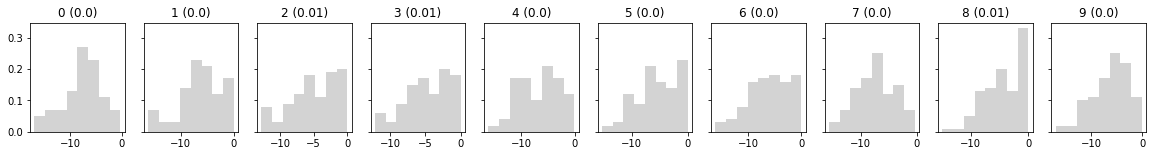

Undecided.


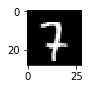

Real:  2


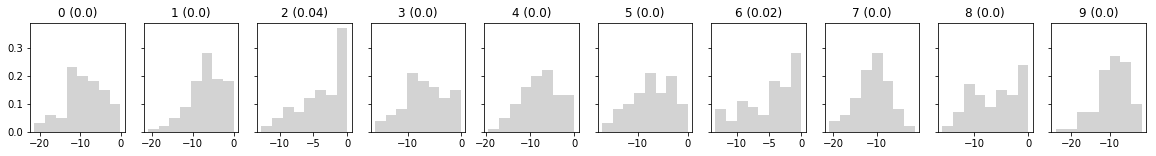

Undecided.


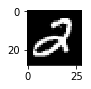

Real:  2


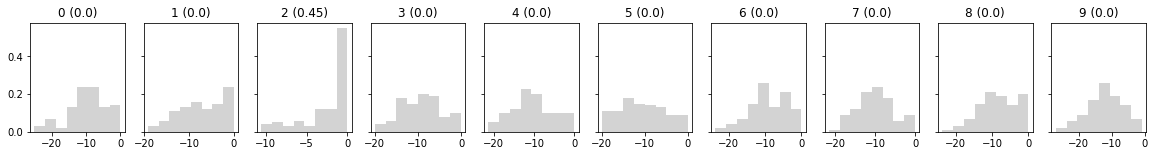

Undecided.


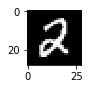

Real:  8


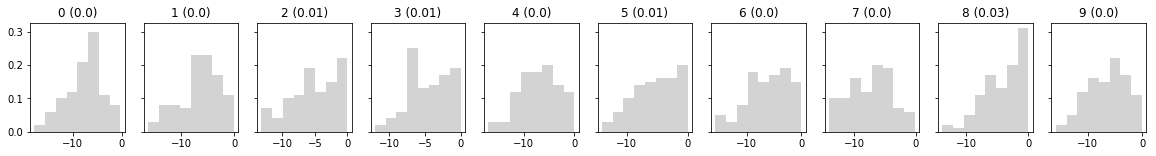

Undecided.


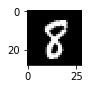

Real:  5


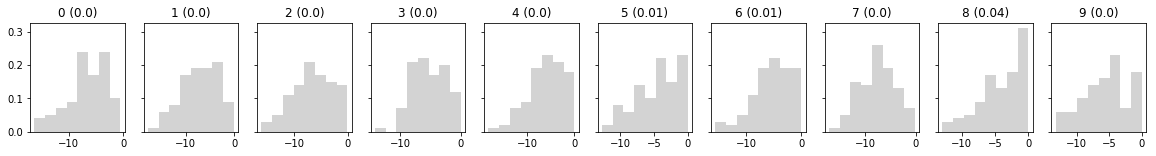

Undecided.


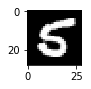

Real:  7


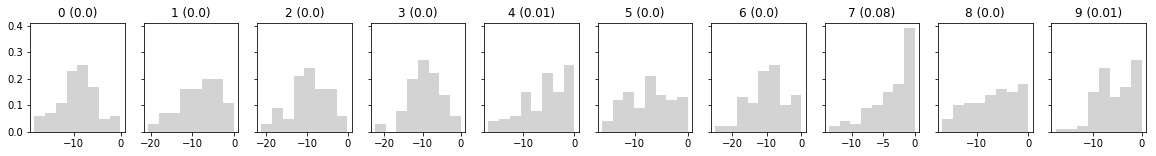

Undecided.


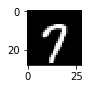

Real:  6


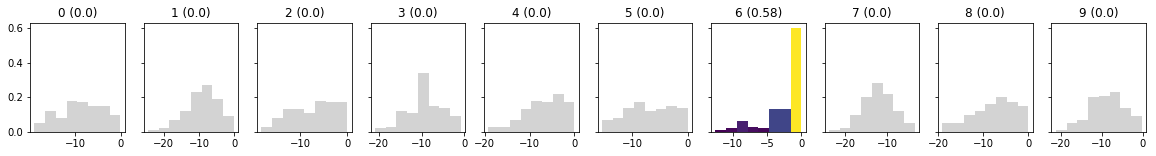

Correct


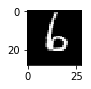

Real:  1


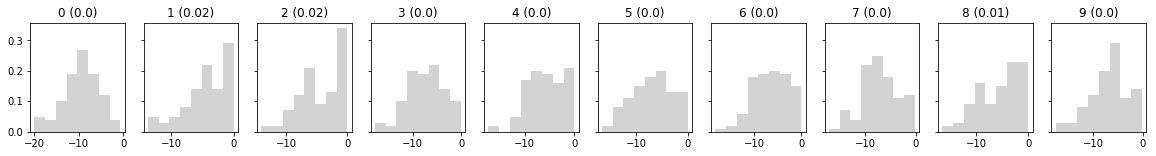

Undecided.


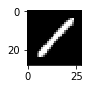

Real:  7


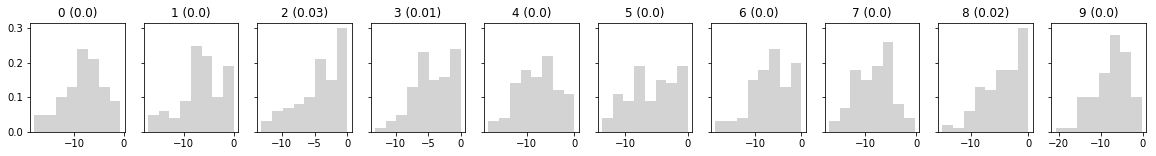

Undecided.


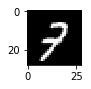

Real:  2


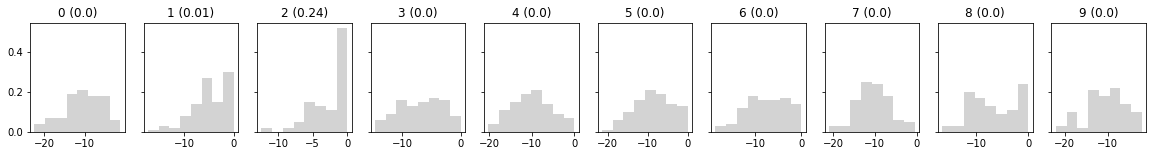

Undecided.


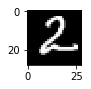

Real:  0


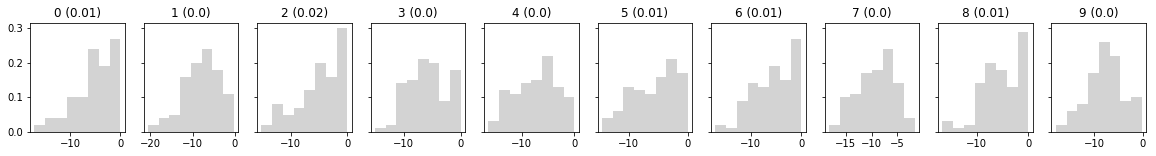

Undecided.


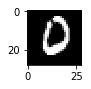

Real:  6


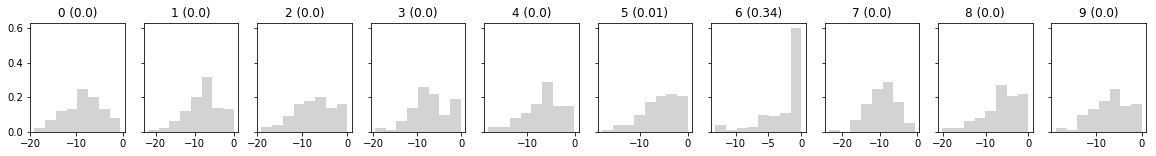

Undecided.


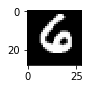

Real:  0


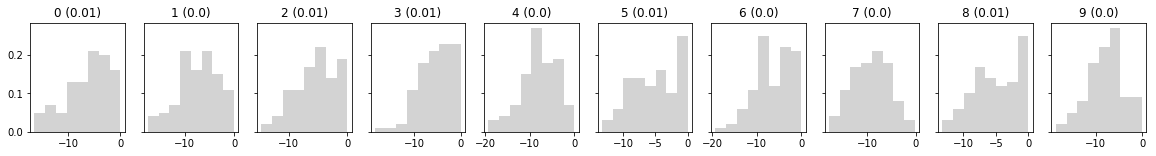

Undecided.


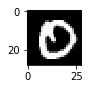

Real:  2


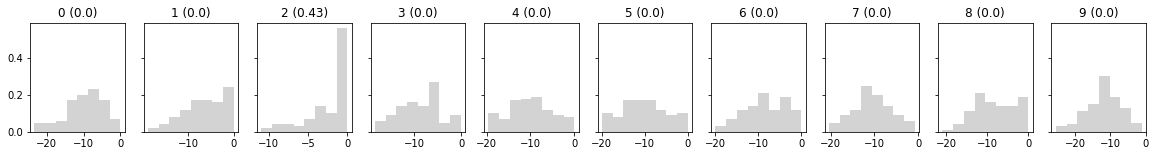

Undecided.


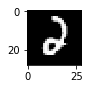

Real:  6


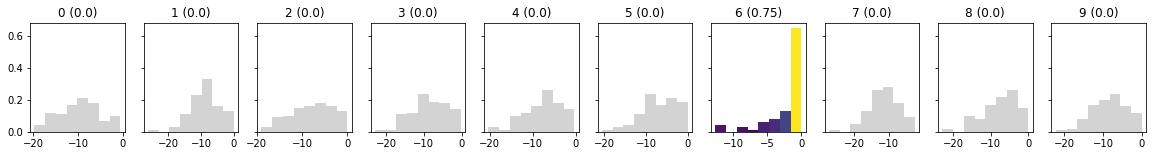

Correct


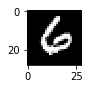

Real:  1


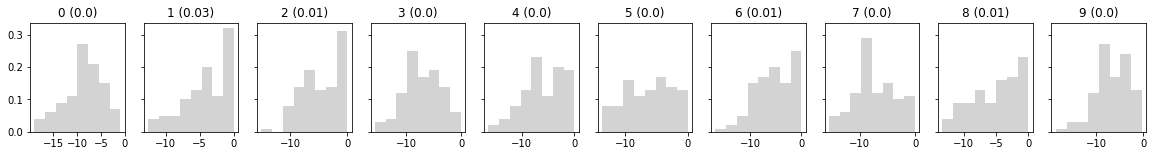

Undecided.


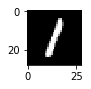

Real:  8


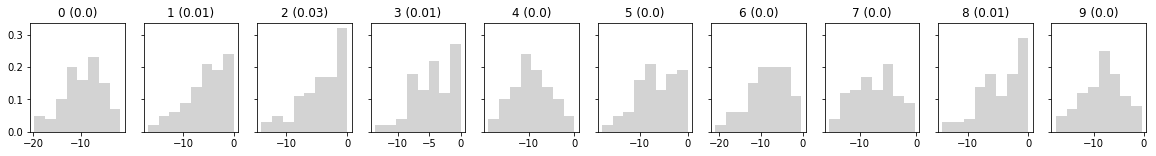

Undecided.


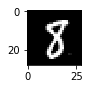

Real:  5


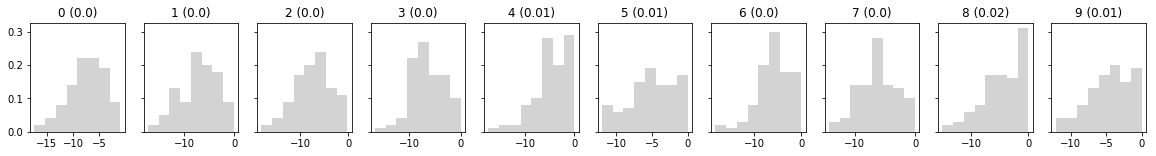

Undecided.


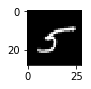

Real:  2


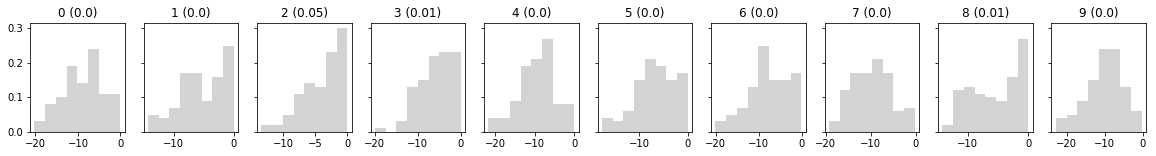

Undecided.


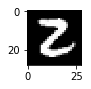

Real:  1


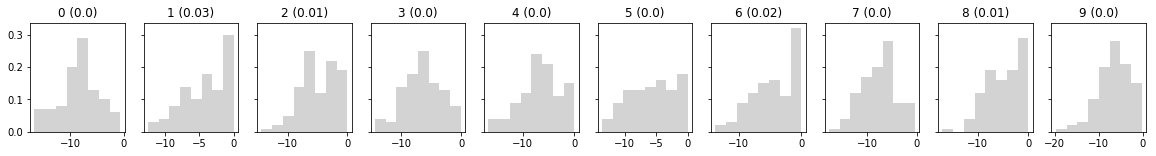

Undecided.


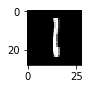

Real:  4


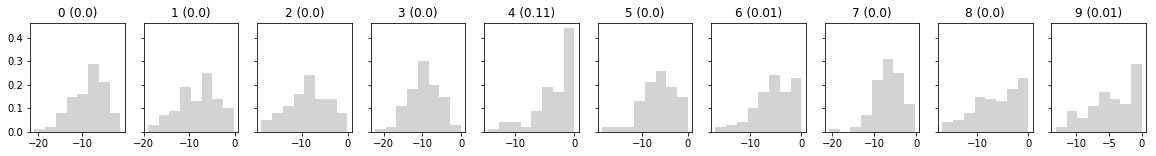

Undecided.


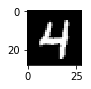

Real:  7


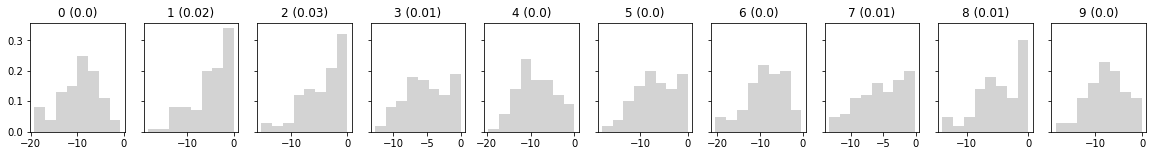

Undecided.


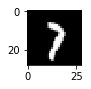

Real:  4


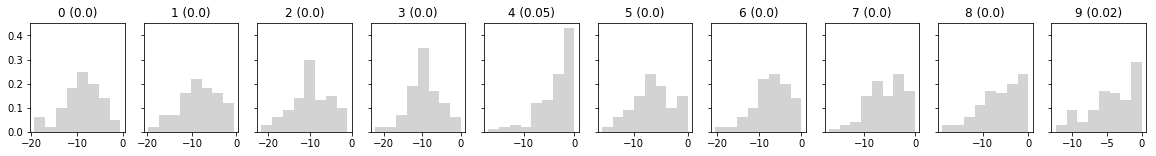

Undecided.


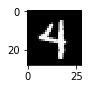

Real:  4


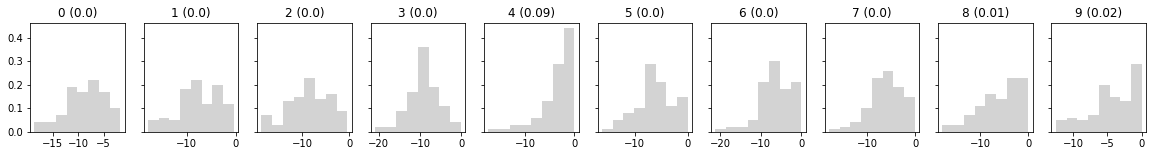

Undecided.


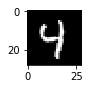

Real:  8


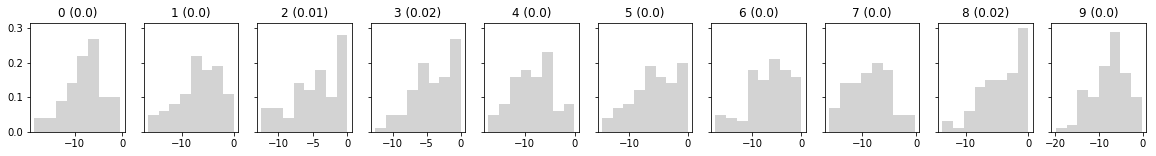

Undecided.


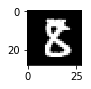

Real:  7


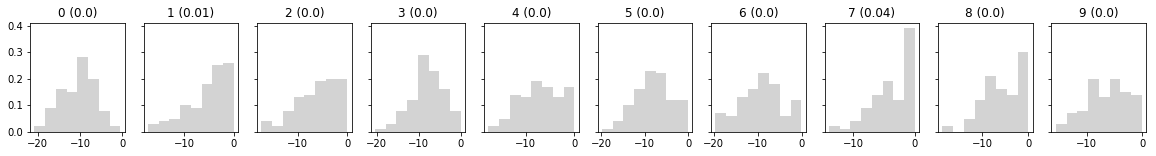

Undecided.


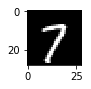

Real:  2


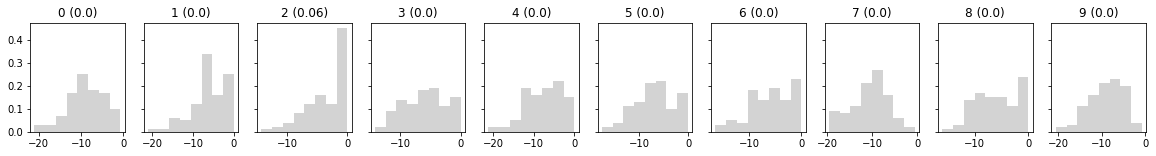

Undecided.


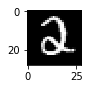

Real:  5


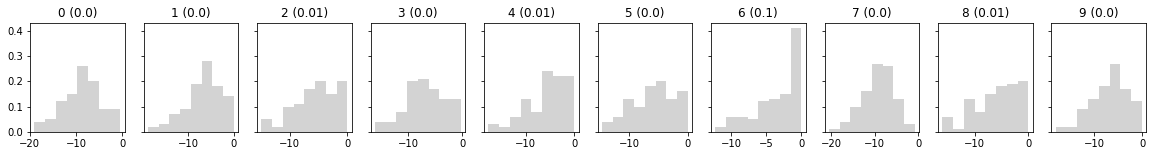

Undecided.


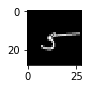

Real:  2


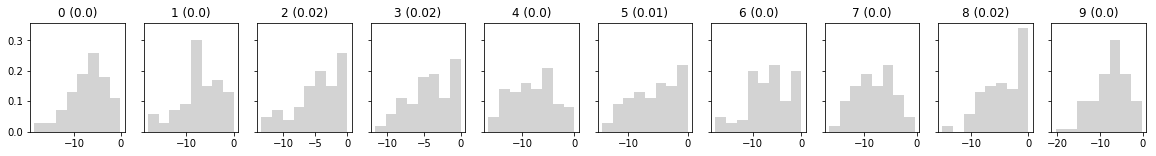

Undecided.


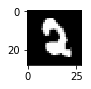

Real:  0


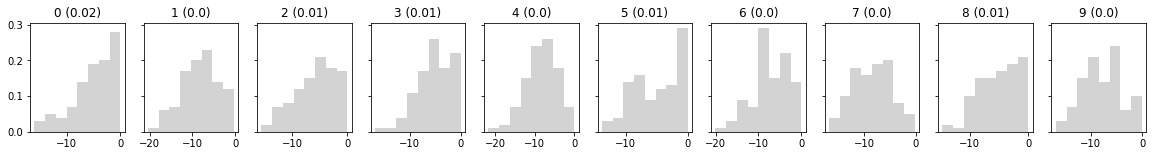

Undecided.


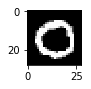

Real:  9


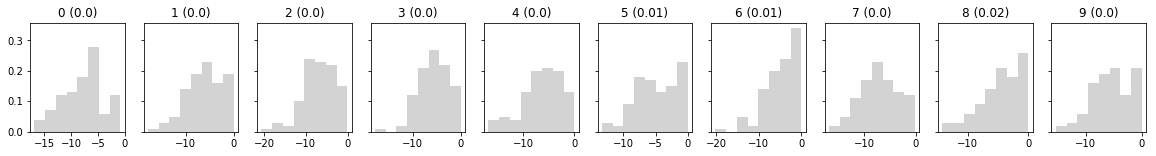

Undecided.


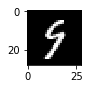

Real:  3


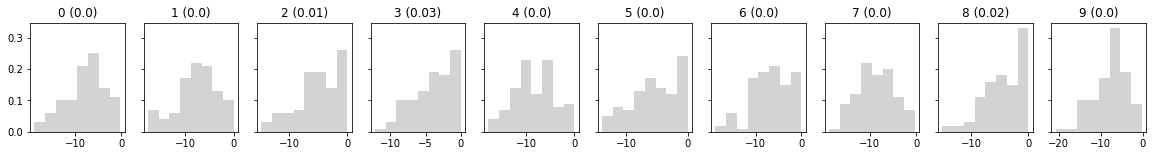

Undecided.


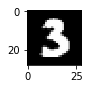

Real:  8


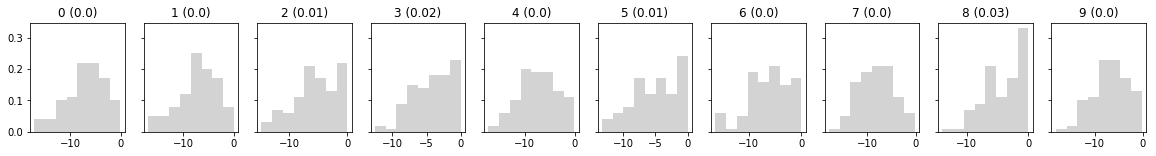

Undecided.


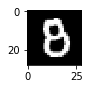

Real:  2


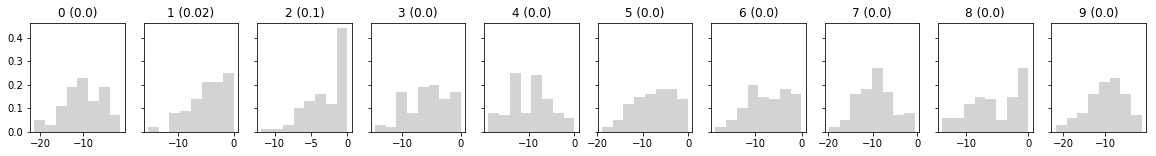

Undecided.


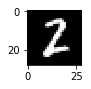

Real:  5


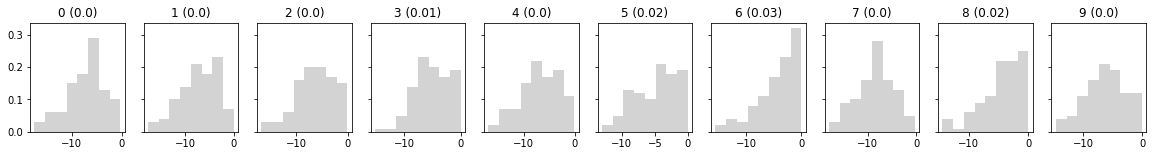

Undecided.


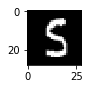

Real:  4


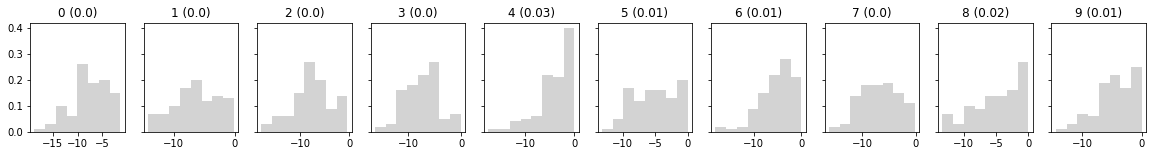

Undecided.


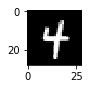

Real:  9


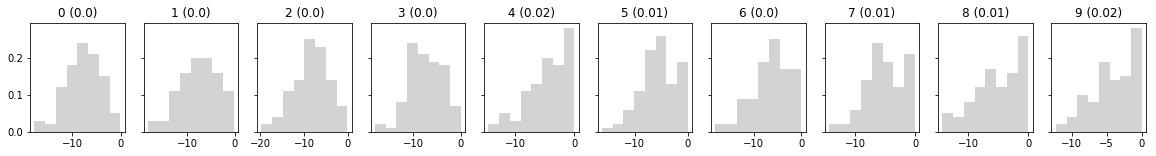

Undecided.


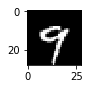

Real:  1


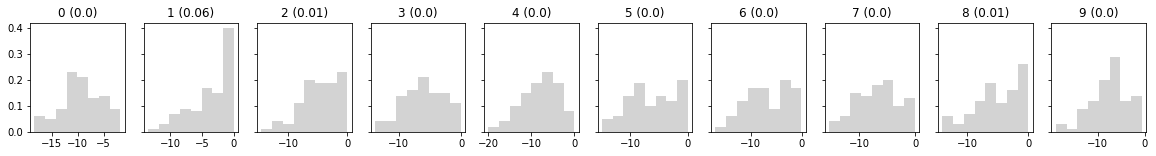

Undecided.


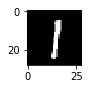

Real:  9


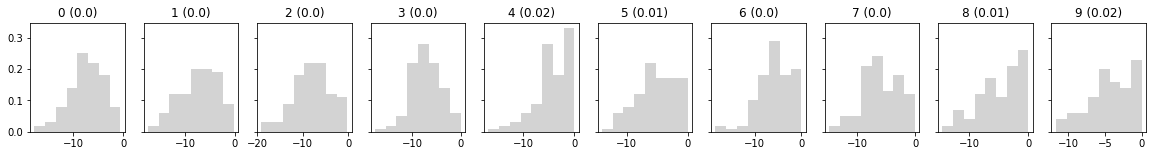

Undecided.


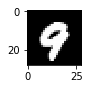

Real:  2


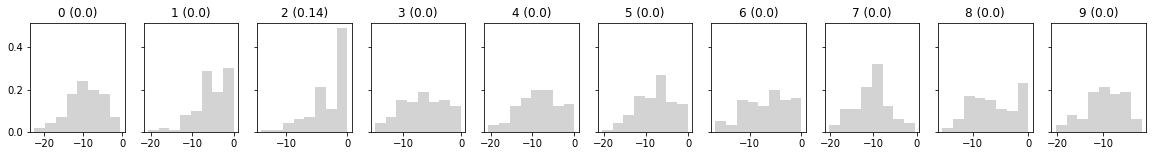

Undecided.


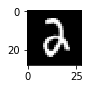

Real:  8


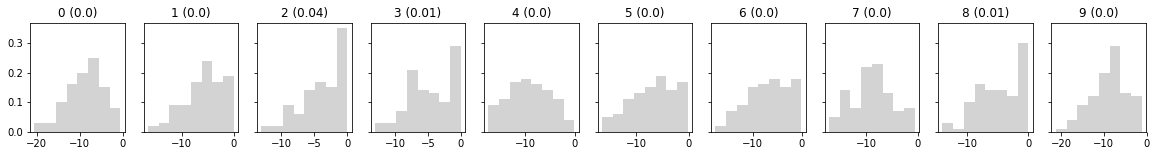

Undecided.


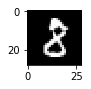

Real:  5


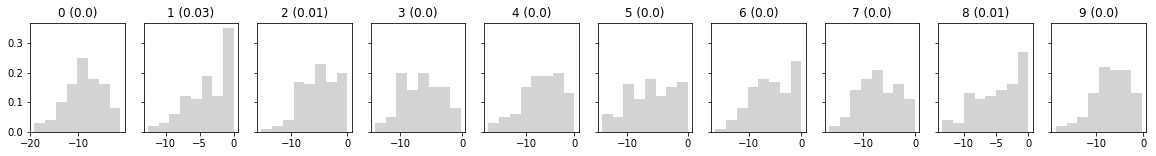

Undecided.


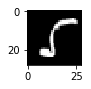

Real:  9


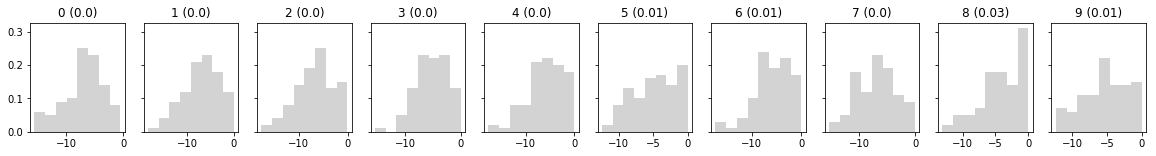

Undecided.


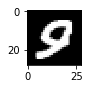

Real:  4


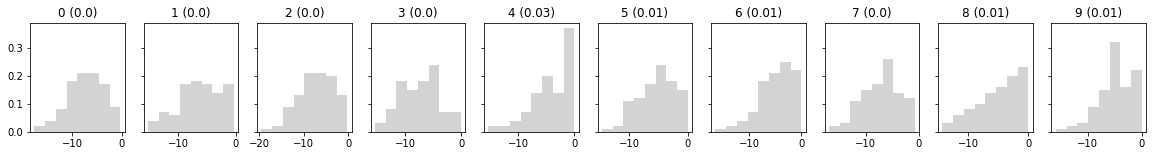

Undecided.


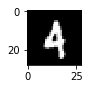

Real:  8


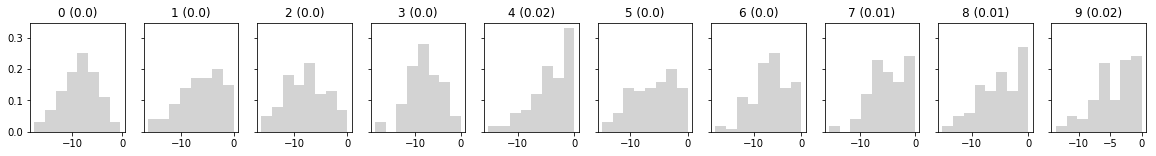

Undecided.


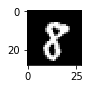

Real:  6


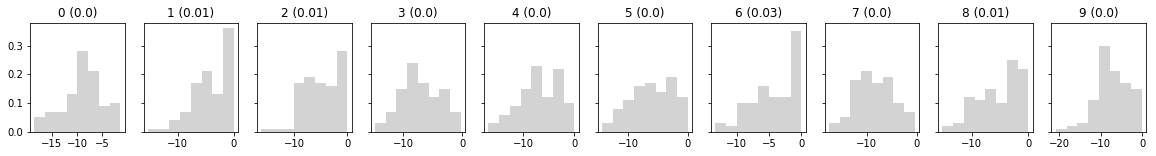

Undecided.


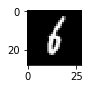

Real:  1


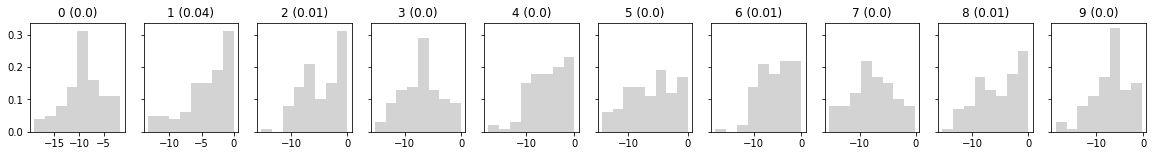

Undecided.


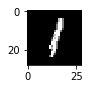

Real:  5


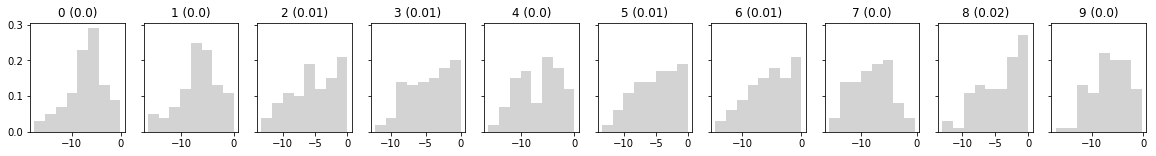

Undecided.


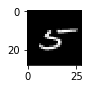

Real:  4


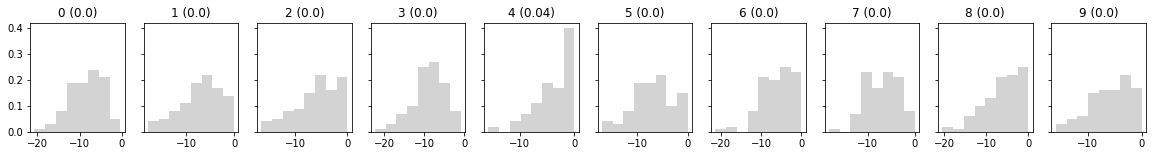

Undecided.


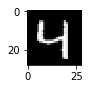

Real:  8


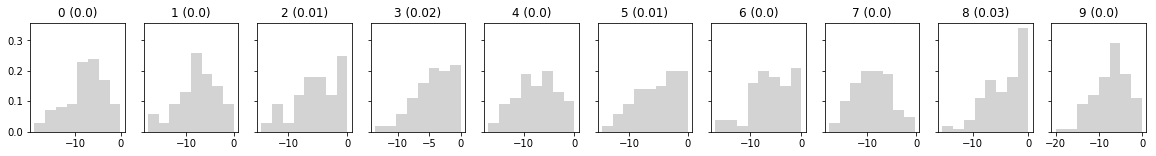

Undecided.


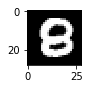

Real:  8


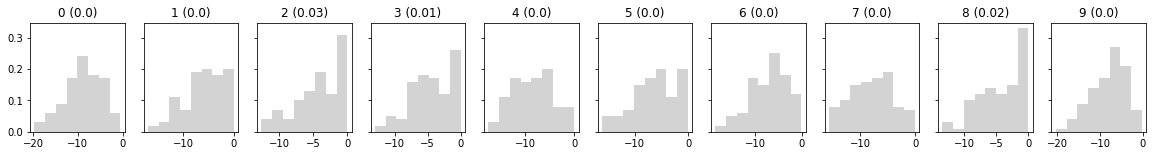

Undecided.


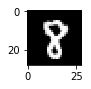

Real:  9


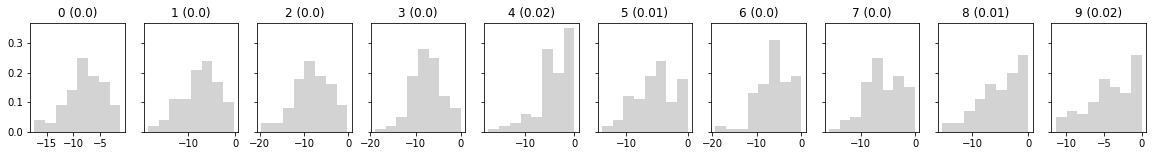

Undecided.


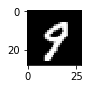

Real:  4


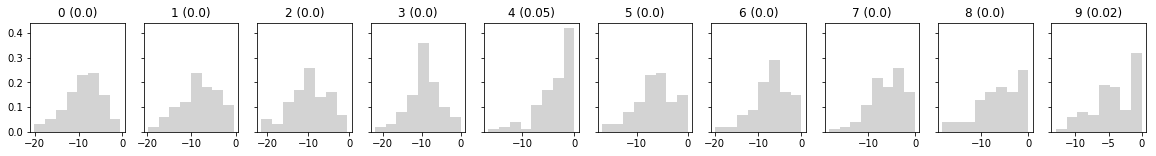

Undecided.


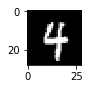

Real:  3


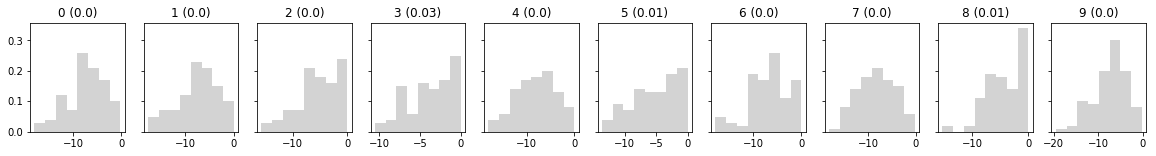

Undecided.


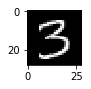

Real:  2


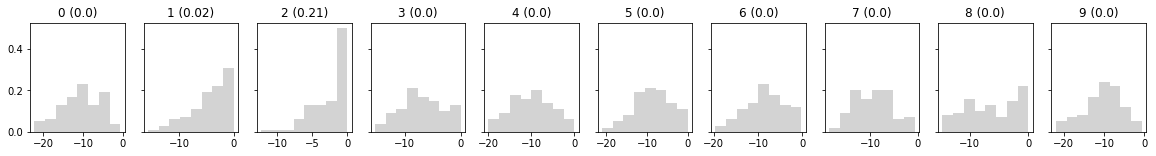

Undecided.


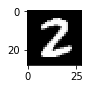

Real:  9


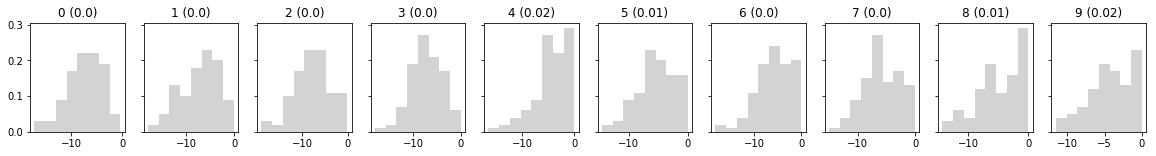

Undecided.


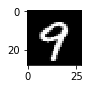

Real:  5


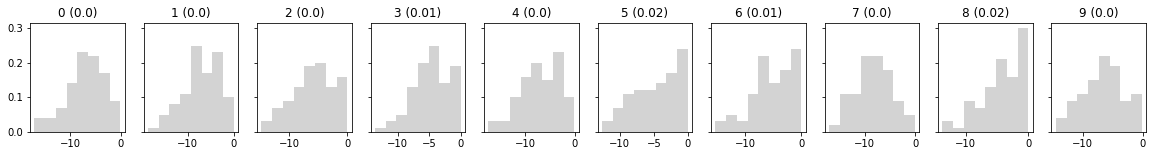

Undecided.


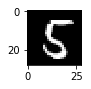

Real:  3


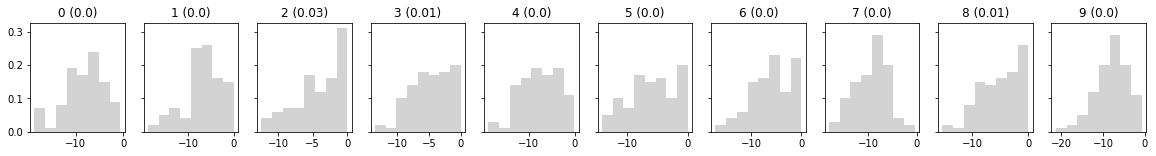

Undecided.


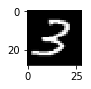

Real:  1


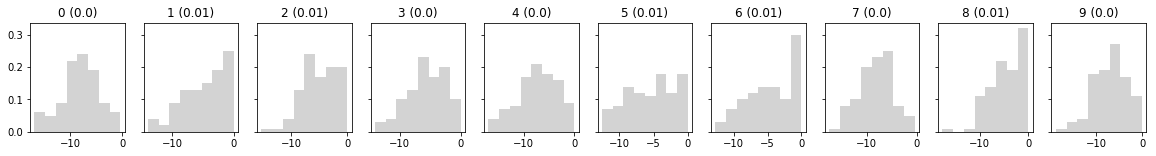

Undecided.


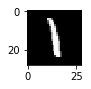

Real:  8


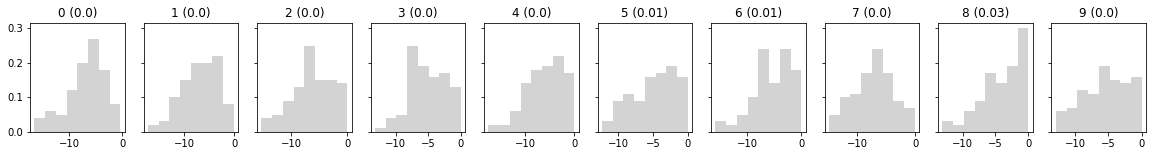

Undecided.


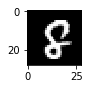

Real:  2


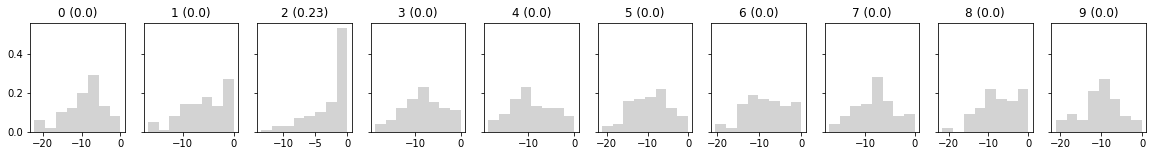

Undecided.


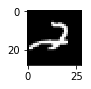

Real:  3


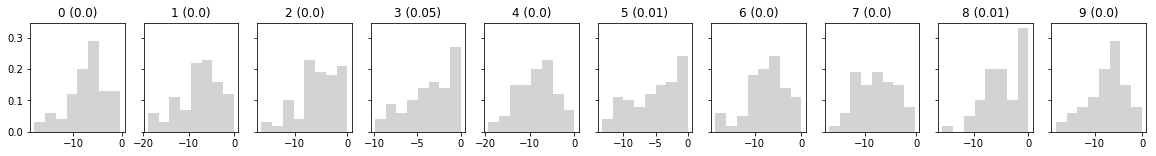

Undecided.


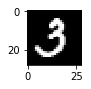

Real:  4


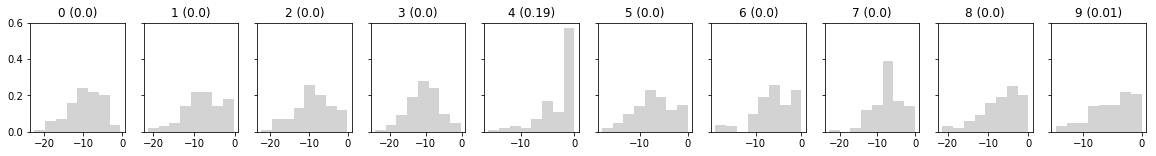

Undecided.


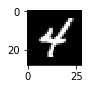

Real:  1


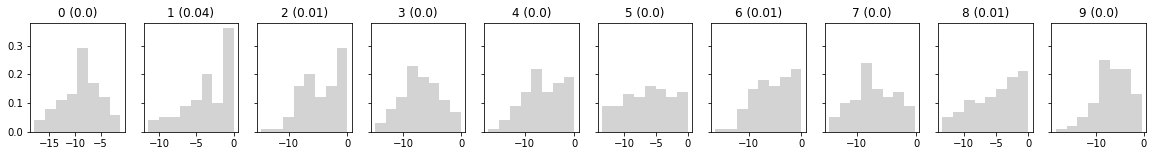

Undecided.


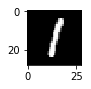

Real:  4


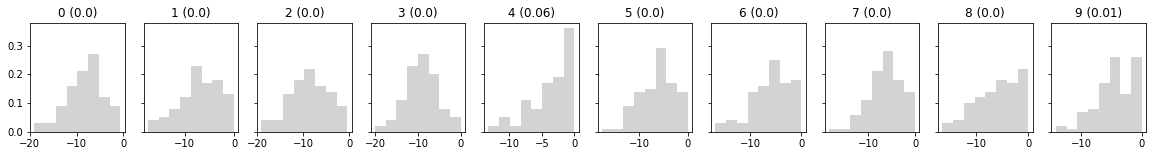

Undecided.


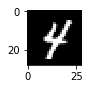

Real:  6


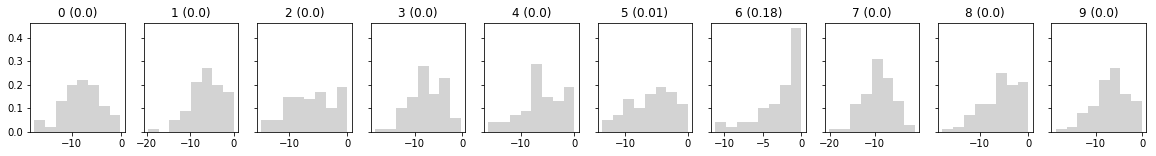

Undecided.


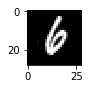

Real:  2


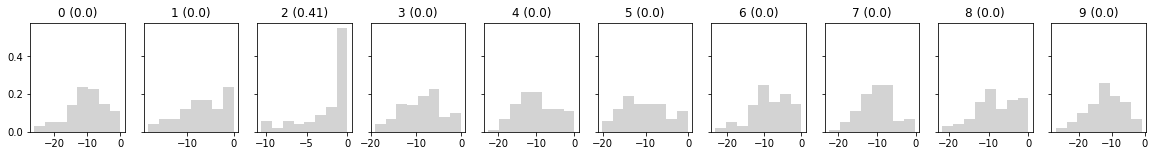

Undecided.


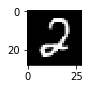

Real:  3


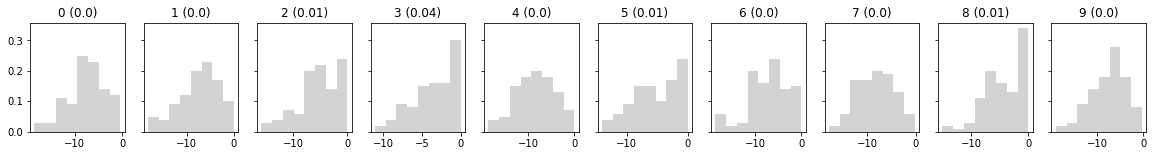

Undecided.


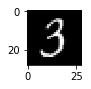

Real:  2


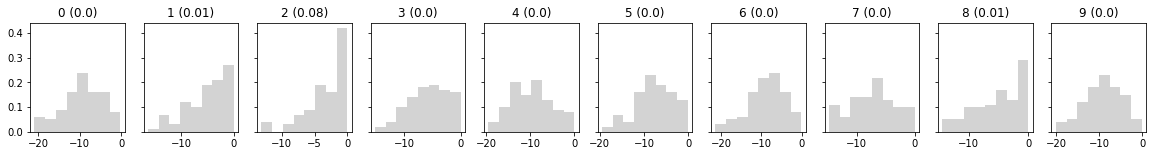

Undecided.


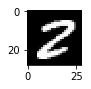

Real:  6


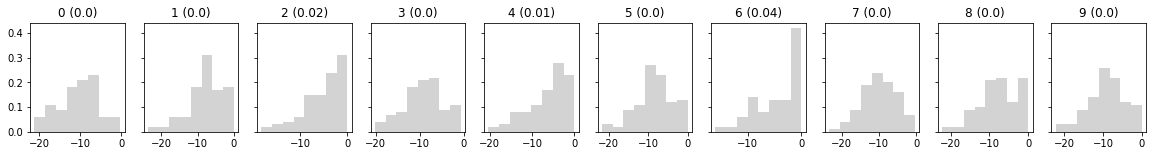

Undecided.


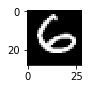

Real:  8


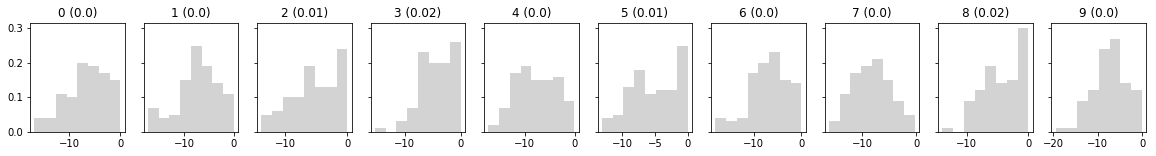

Undecided.


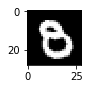

Real:  8


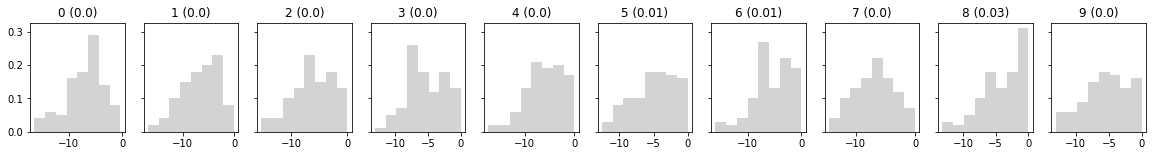

Undecided.


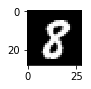

Real:  7


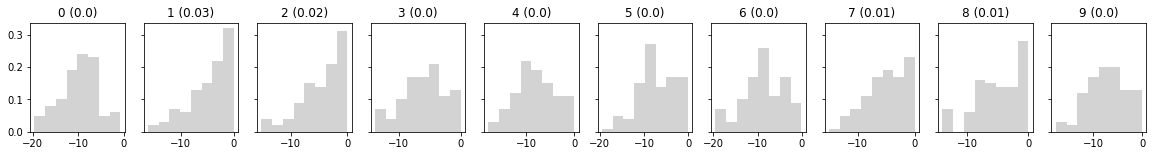

Undecided.


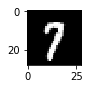

Real:  0


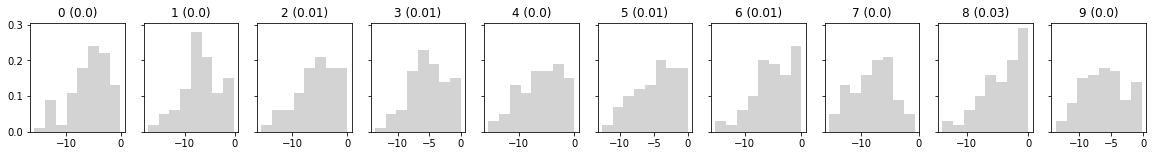

Undecided.


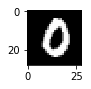

Real:  4


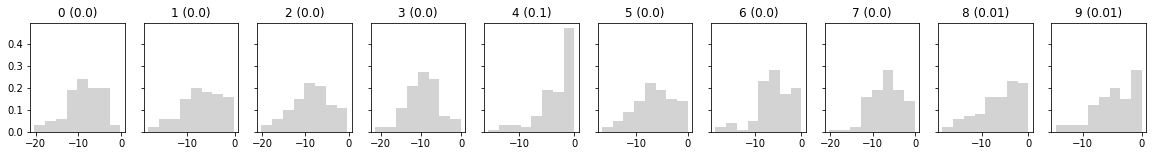

Undecided.


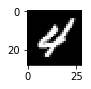

Real:  2


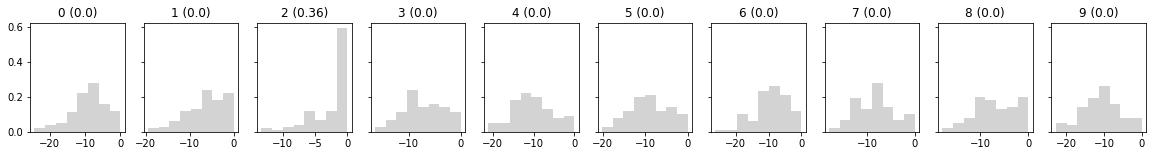

Undecided.


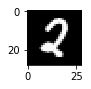

Real:  4


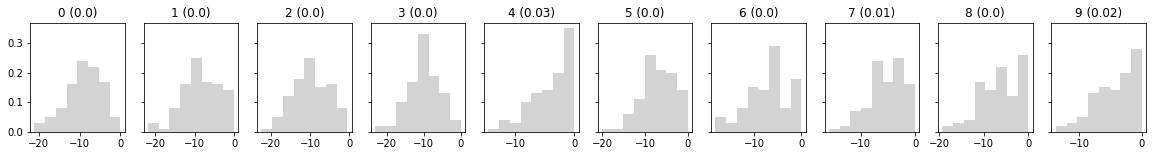

Undecided.


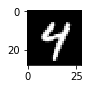

Real:  9


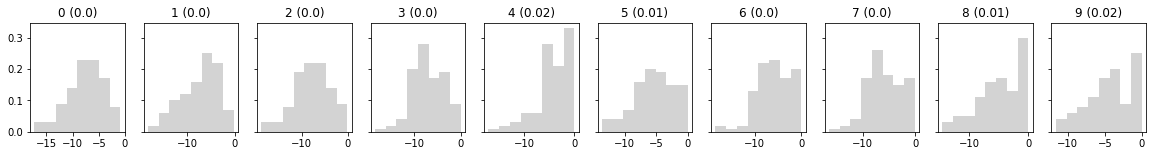

Undecided.


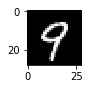

Real:  9


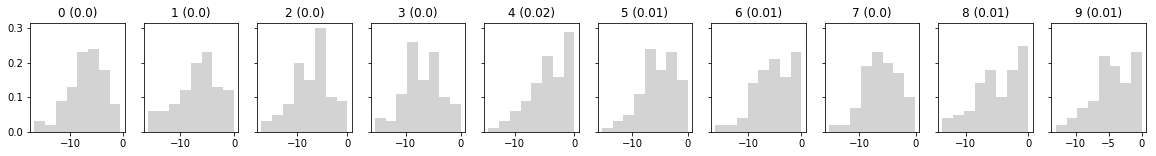

Undecided.


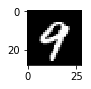

Real:  3


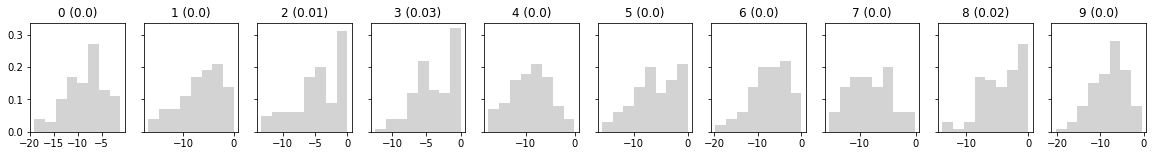

Undecided.


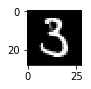

Real:  8


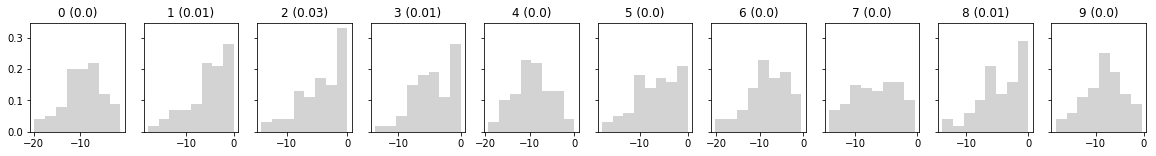

Undecided.


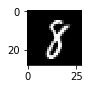

Real:  2


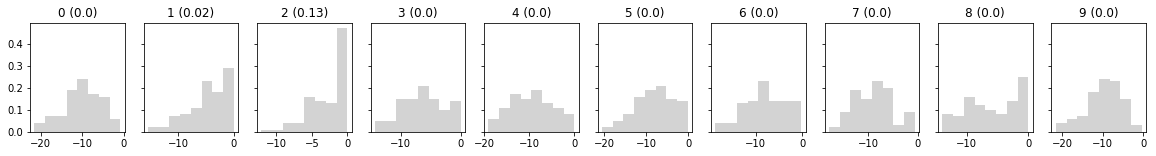

Undecided.


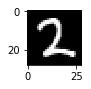

Real:  3


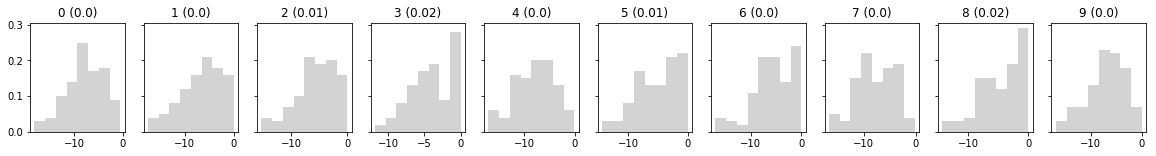

Undecided.


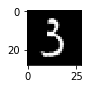

Real:  0


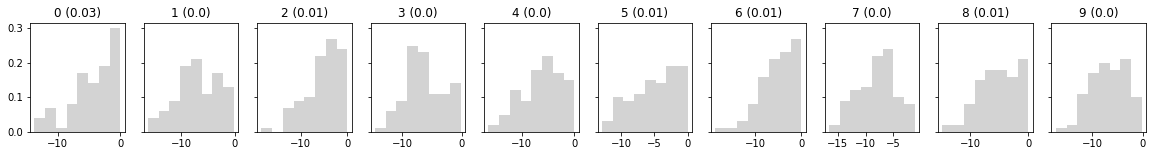

Undecided.


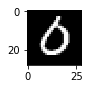

Real:  4


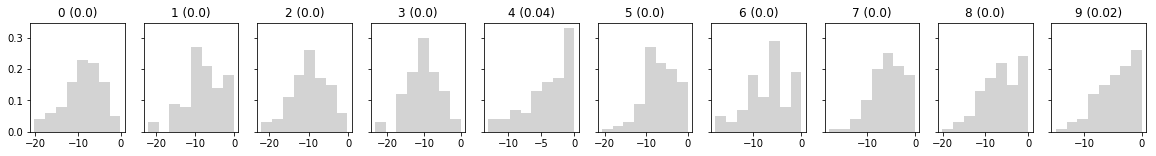

Undecided.


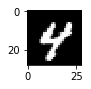

Real:  8


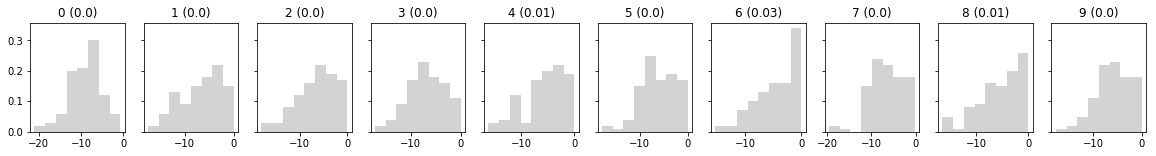

Undecided.


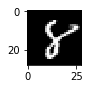

Real:  5


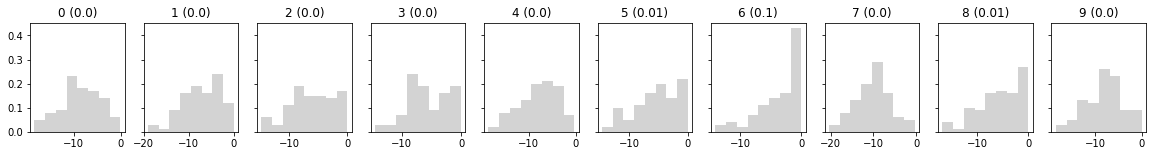

Undecided.


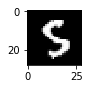

Real:  4


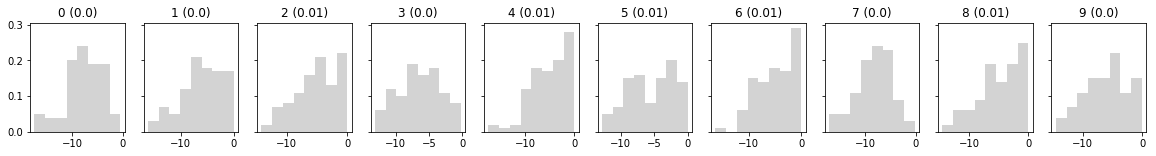

Undecided.


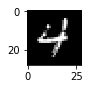

Real:  0


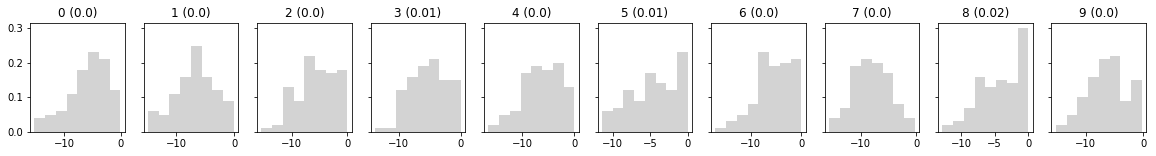

Undecided.


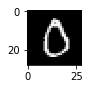

Real:  3


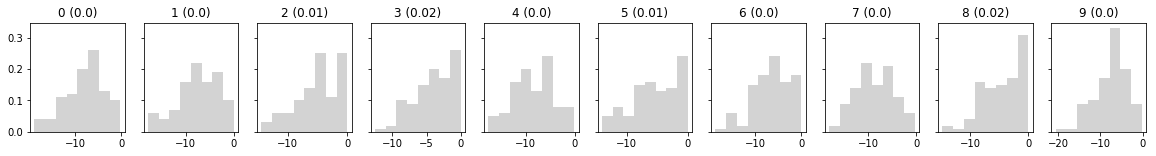

Undecided.


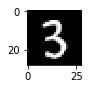

Real:  0


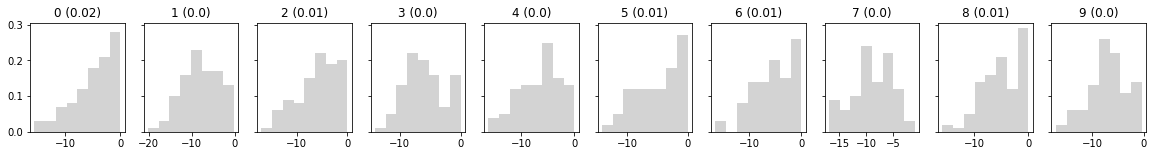

Undecided.


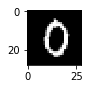

Real:  6


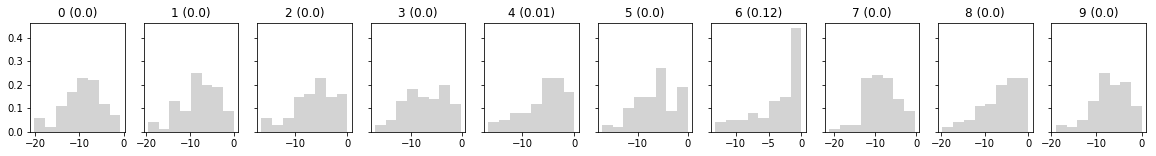

Undecided.


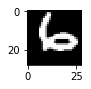

Real:  0


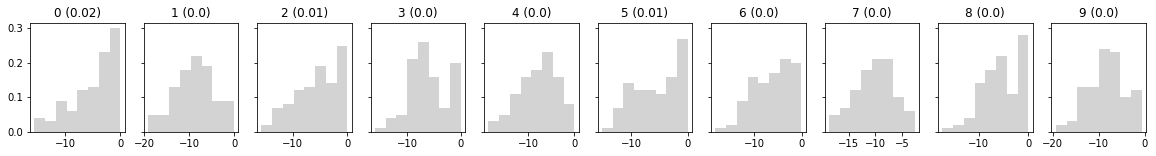

Undecided.


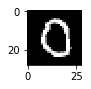

Real:  5


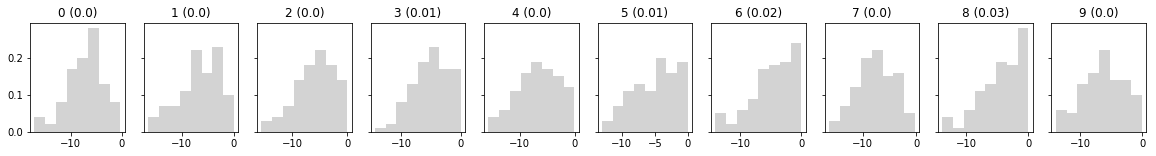

Undecided.


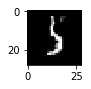

Real:  3


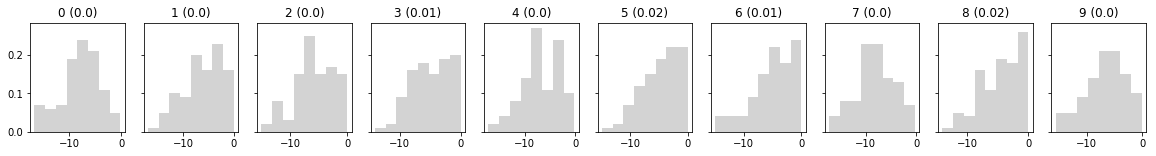

Undecided.


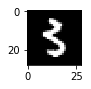

Real:  1


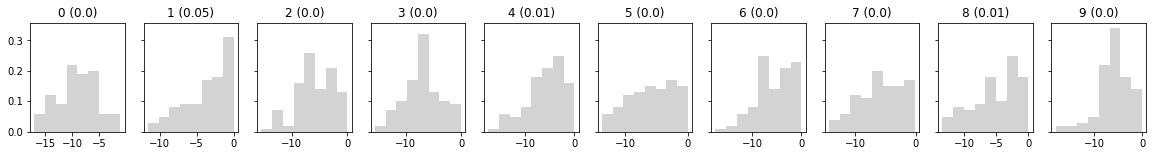

Undecided.


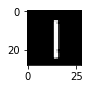

Real:  9


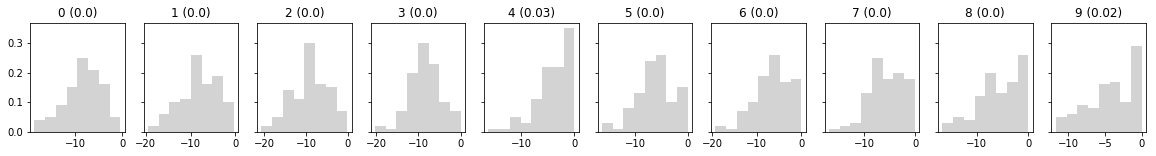

Undecided.


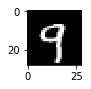

Real:  7


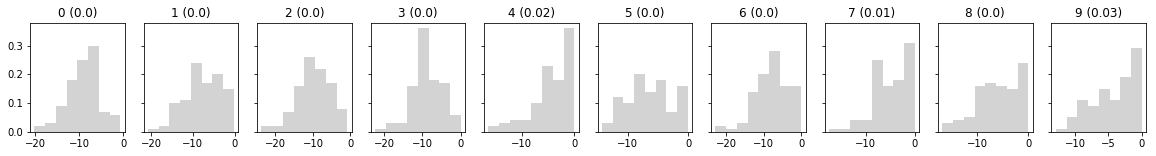

Undecided.


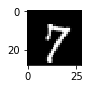

Real:  6


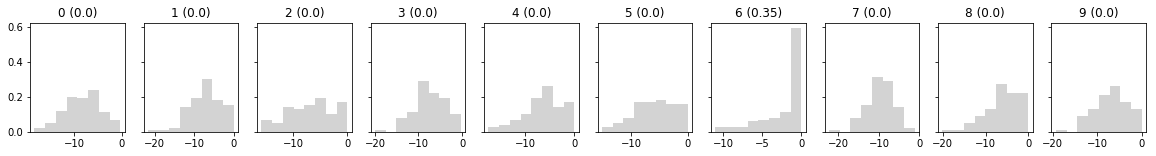

Undecided.


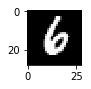

Real:  5


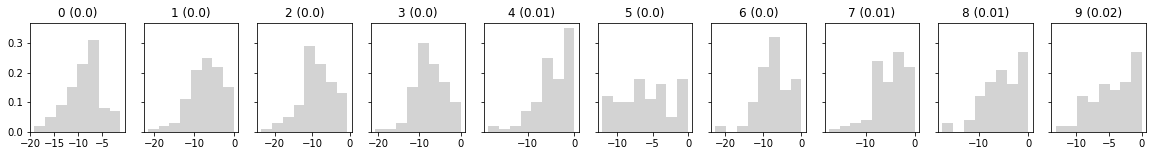

Undecided.


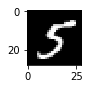

Summary
Total images:  100
Predicted for:  2
Accuracy when predicted:  1.0


(100, 2.0, 2)

In [20]:
test_batch(images[:100], labels[:100])

In [21]:
# generate random data

images_random = torch.rand(100,28,28)
labels_random = torch.randint(0,10, (100,))

Real:  2


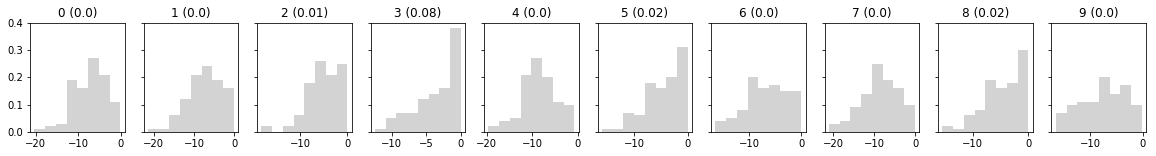

Undecided.


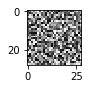

Real:  6


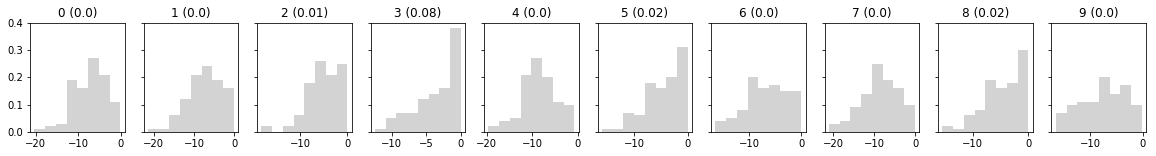

Undecided.


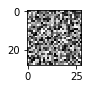

Real:  8


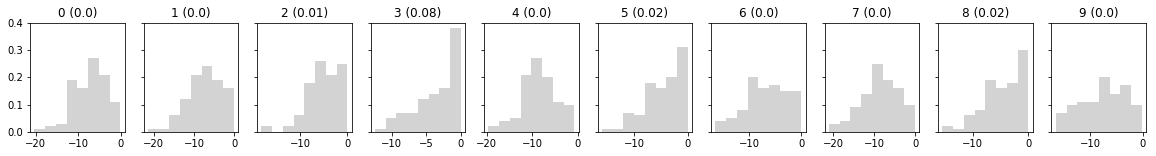

Undecided.


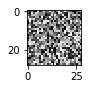

Real:  2


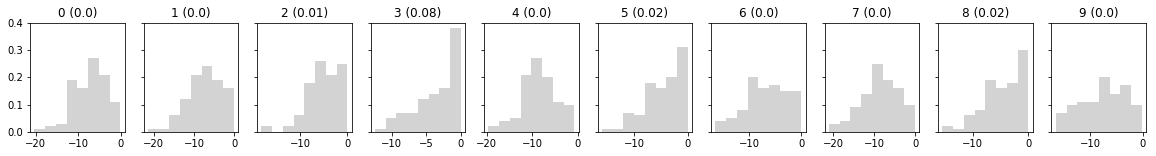

Undecided.


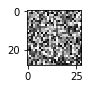

Real:  4


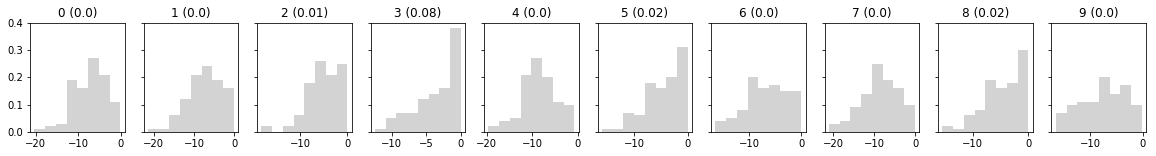

Undecided.


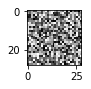

Real:  6


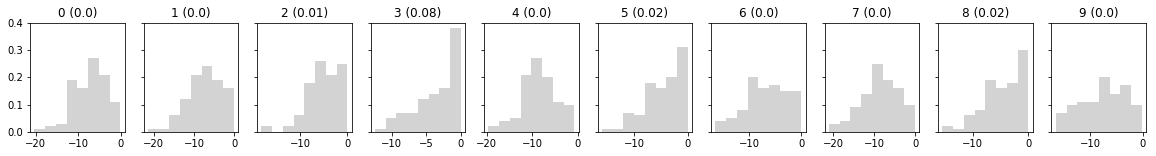

Undecided.


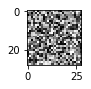

Real:  4


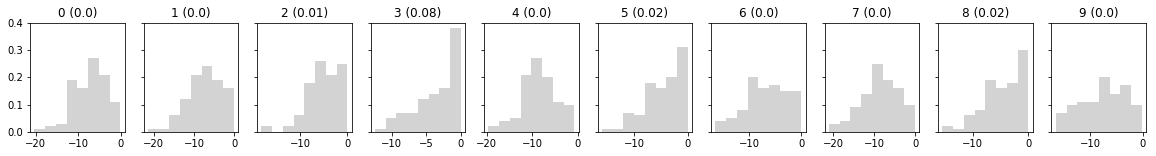

Undecided.


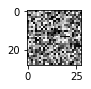

Real:  4


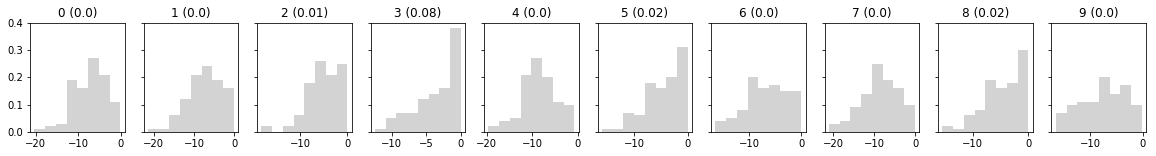

Undecided.


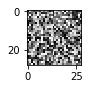

Real:  7


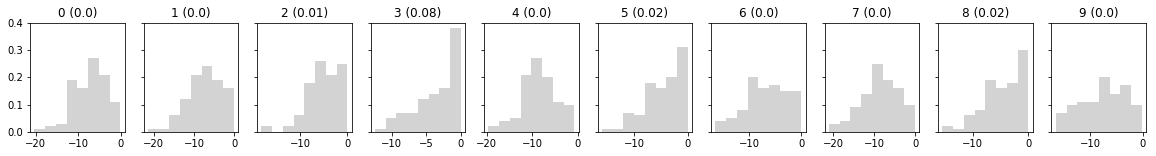

Undecided.


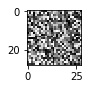

Real:  2


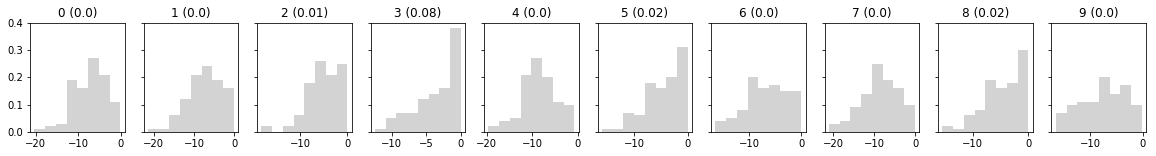

Undecided.


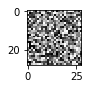

Real:  6


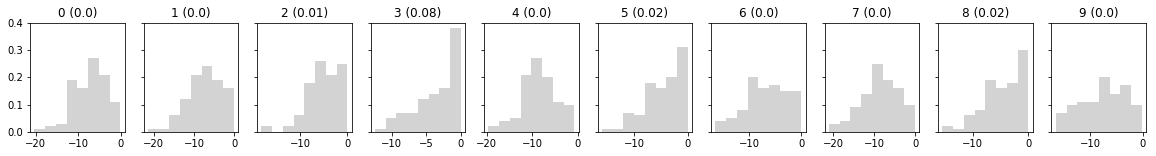

Undecided.


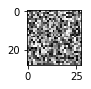

Real:  5


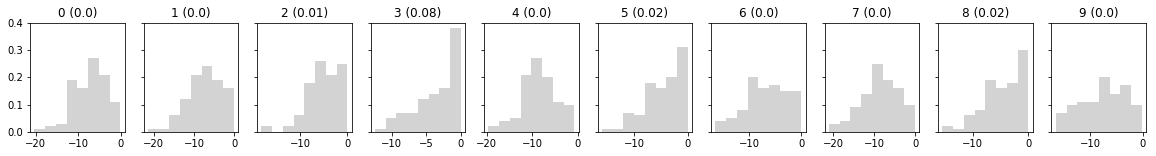

Undecided.


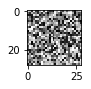

Real:  7


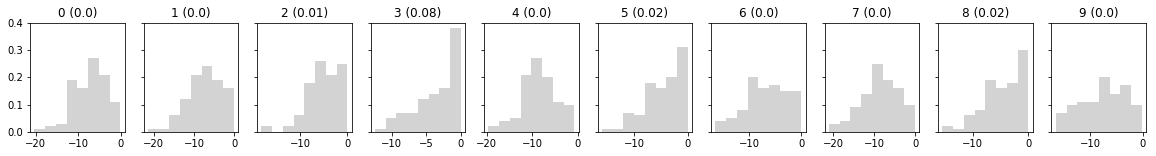

Undecided.


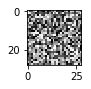

Real:  5


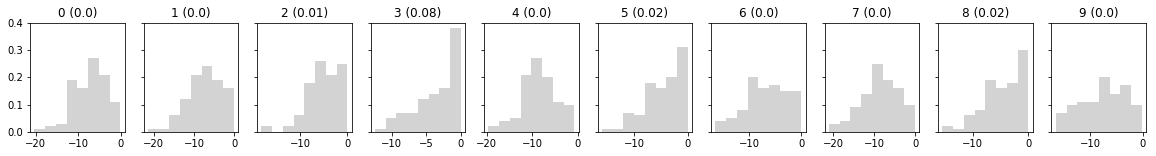

Undecided.


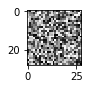

Real:  9


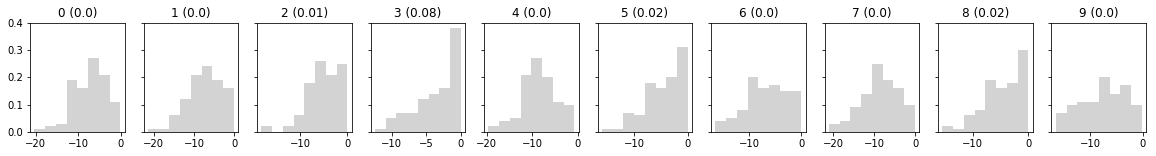

Undecided.


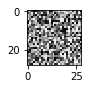

Real:  1


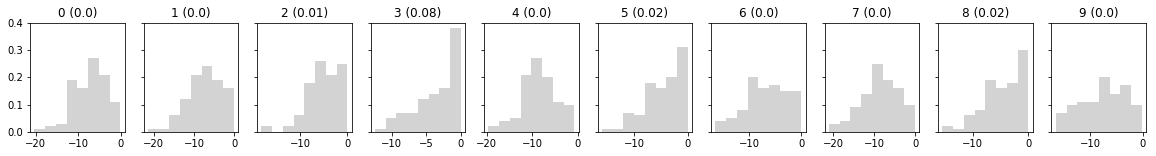

Undecided.


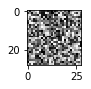

Real:  3


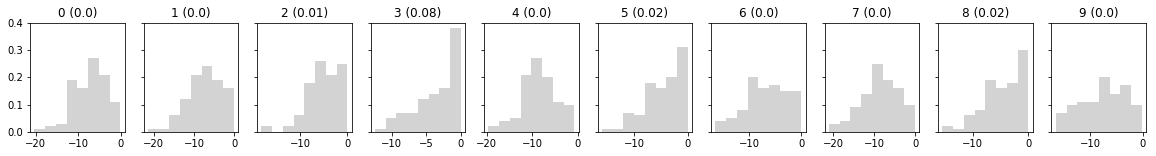

Undecided.


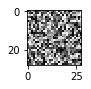

Real:  6


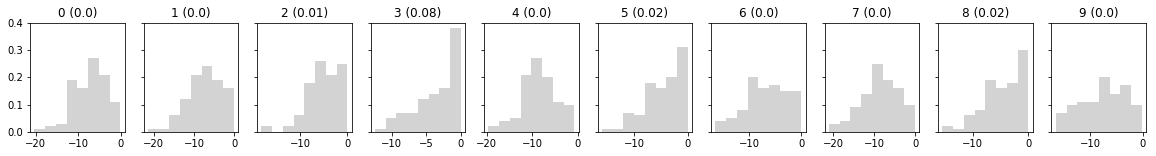

Undecided.


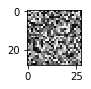

Real:  7


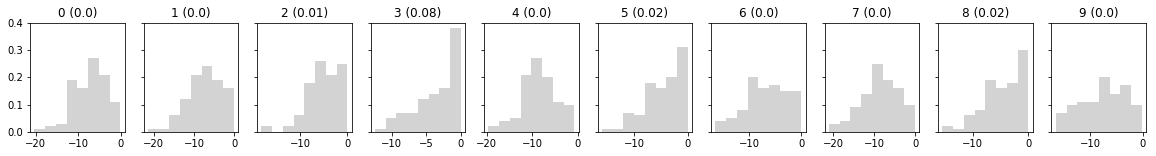

Undecided.


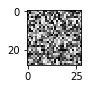

Real:  0


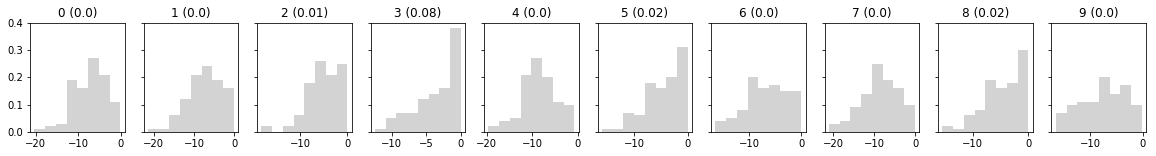

Undecided.


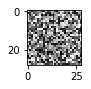

Real:  7


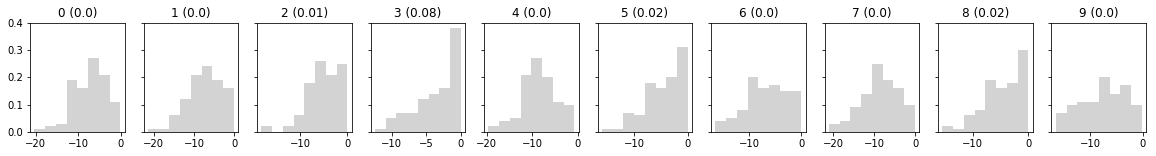

Undecided.


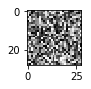

Real:  0


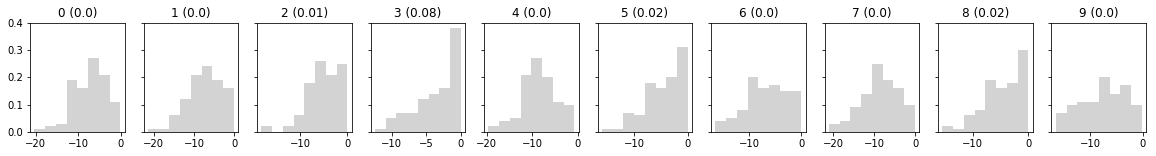

Undecided.


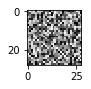

Real:  4


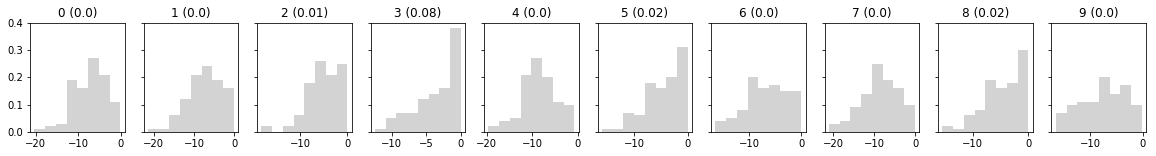

Undecided.


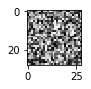

Real:  2


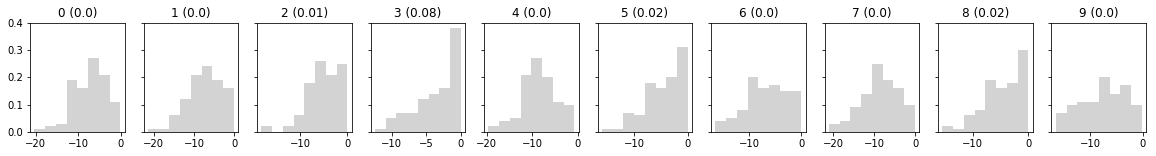

Undecided.


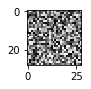

Real:  2


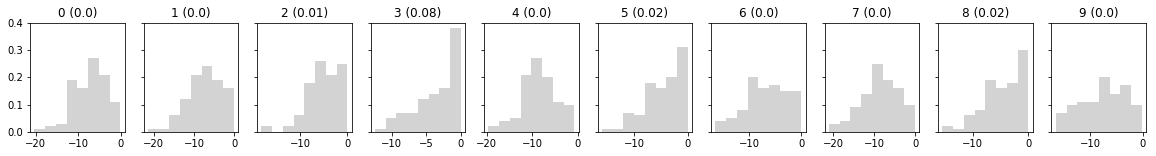

Undecided.


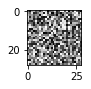

Real:  8


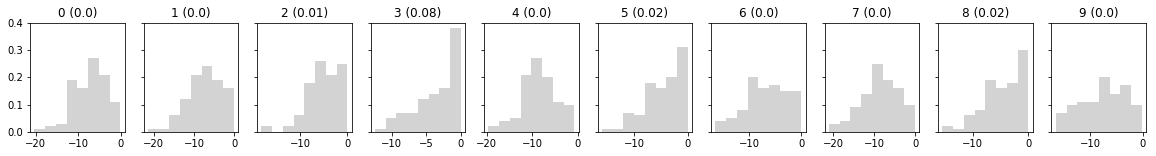

Undecided.


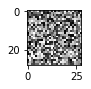

Real:  3


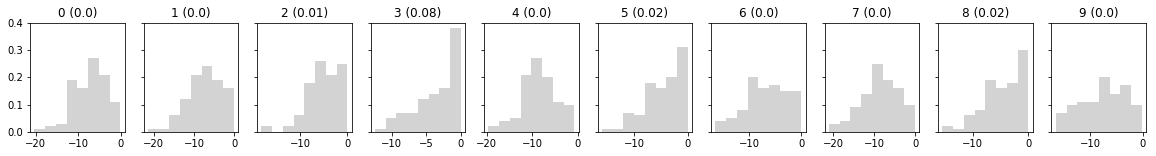

Undecided.


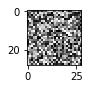

Real:  7


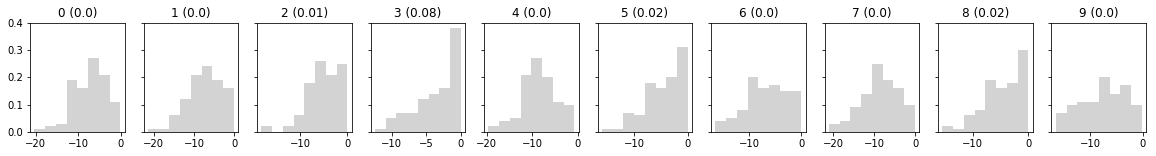

Undecided.


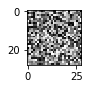

Real:  3


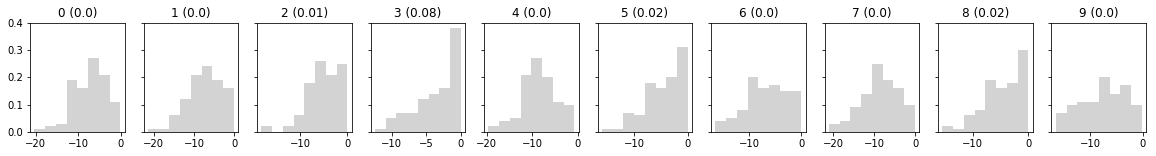

Undecided.


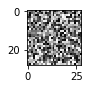

Real:  6


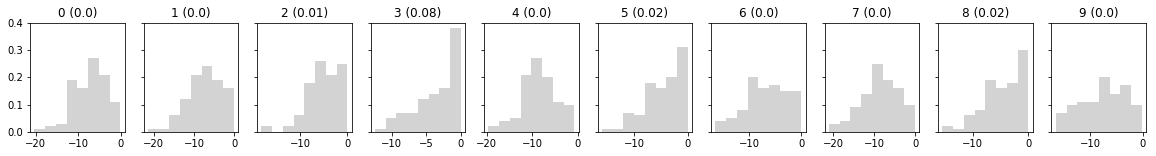

Undecided.


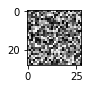

Real:  1


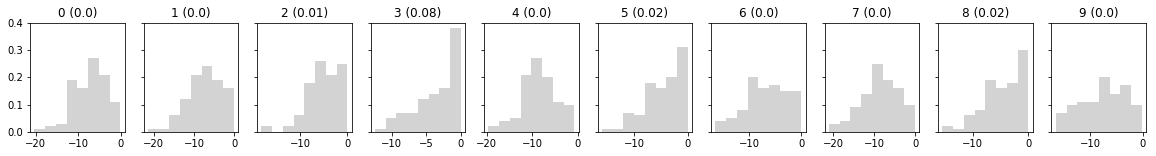

Undecided.


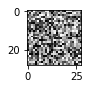

Real:  9


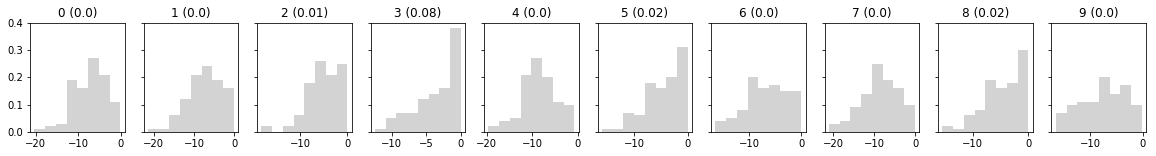

Undecided.


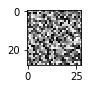

Real:  3


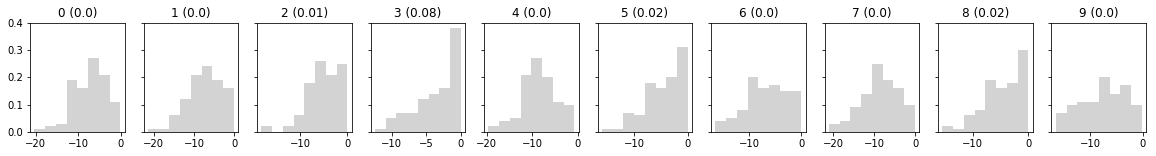

Undecided.


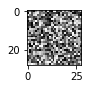

Real:  0


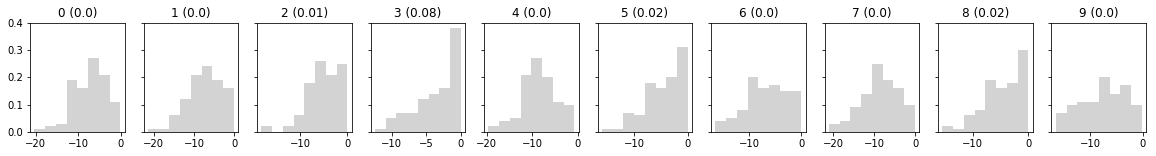

Undecided.


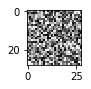

Real:  2


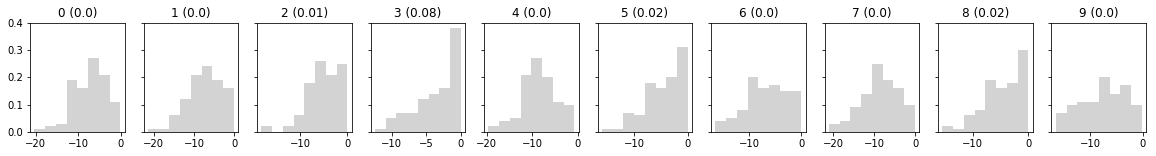

Undecided.


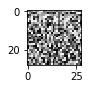

Real:  2


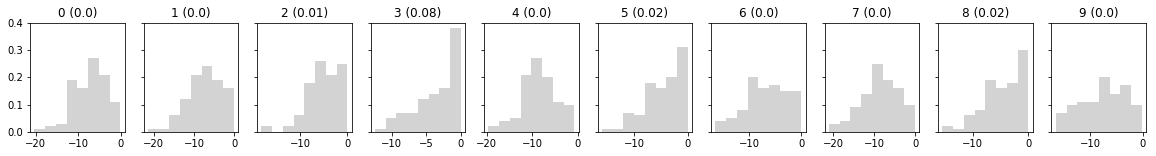

Undecided.


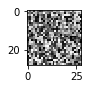

Real:  1


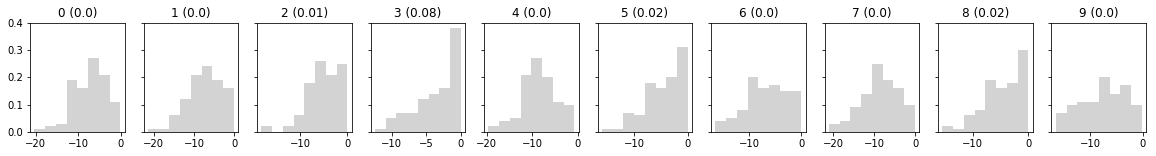

Undecided.


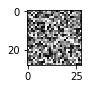

Real:  3


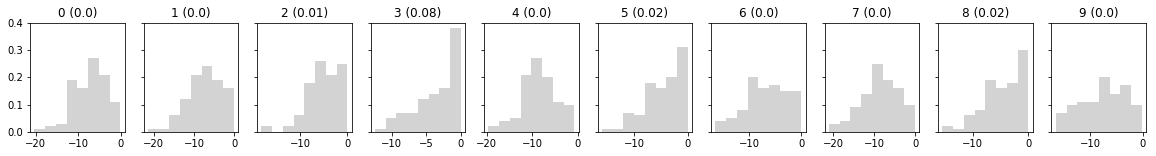

Undecided.


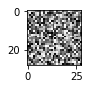

Real:  7


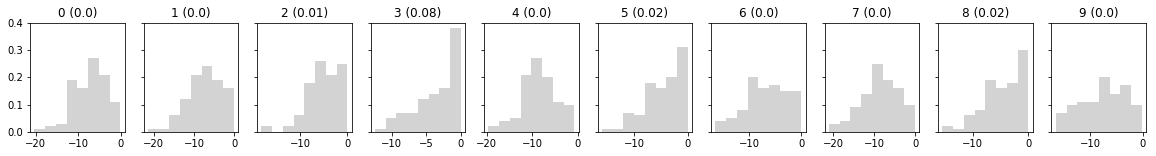

Undecided.


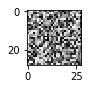

Real:  9


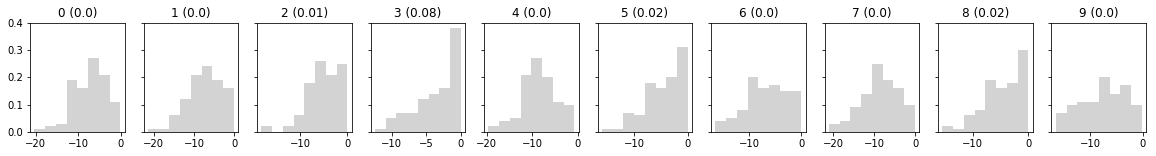

Undecided.


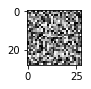

Real:  9


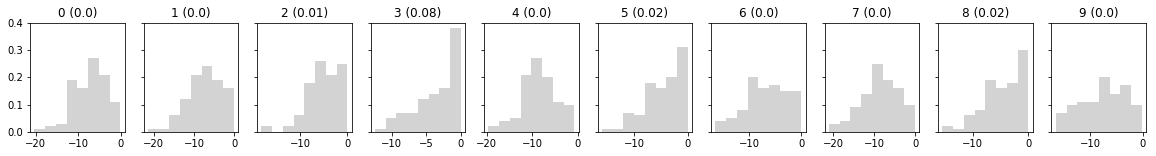

Undecided.


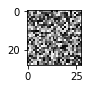

Real:  3


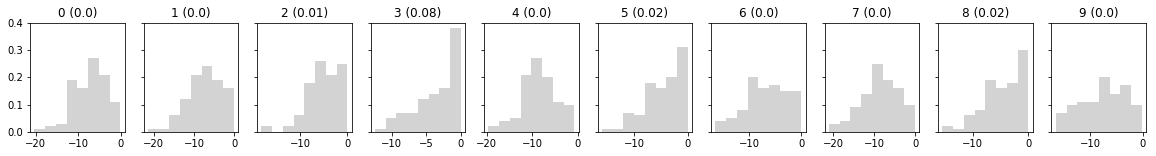

Undecided.


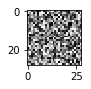

Real:  9


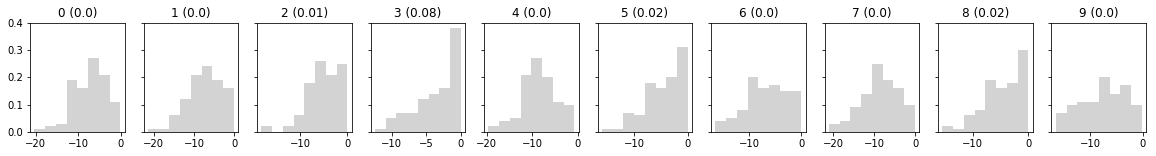

Undecided.


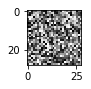

Real:  7


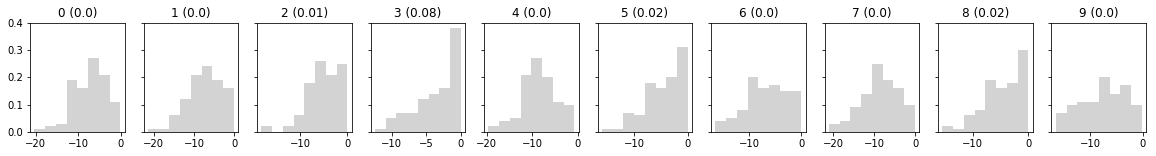

Undecided.


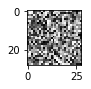

Real:  0


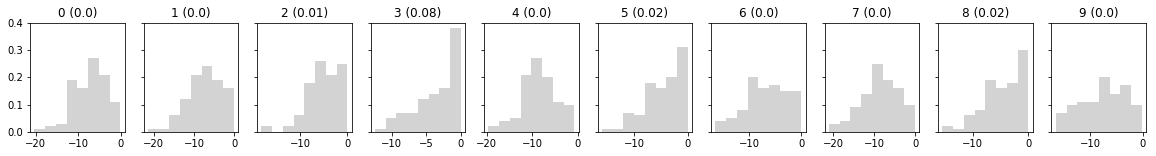

Undecided.


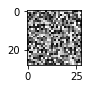

Real:  3


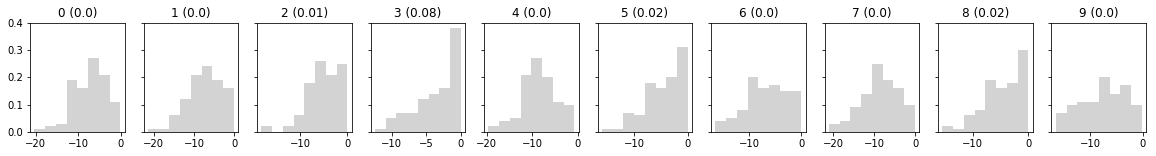

Undecided.


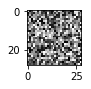

Real:  0


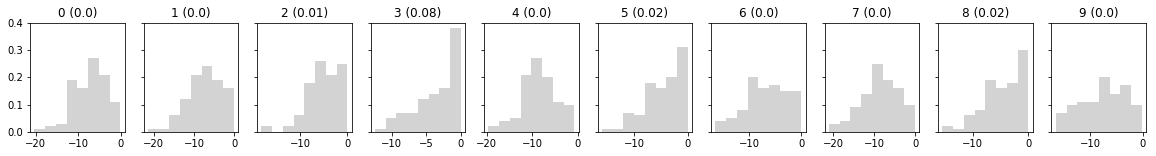

Undecided.


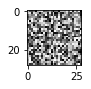

Real:  6


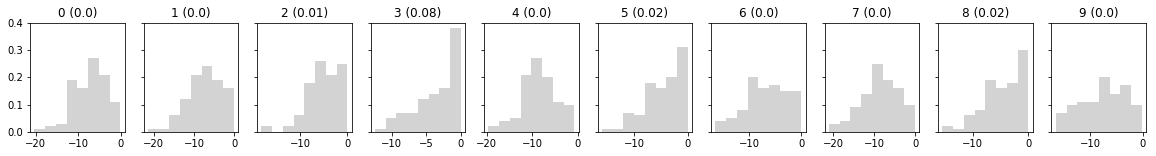

Undecided.


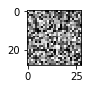

Real:  3


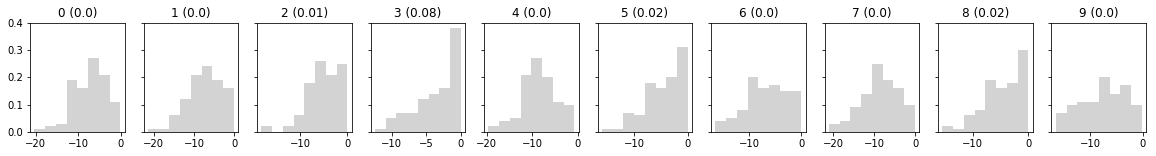

Undecided.


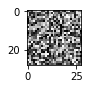

Real:  5


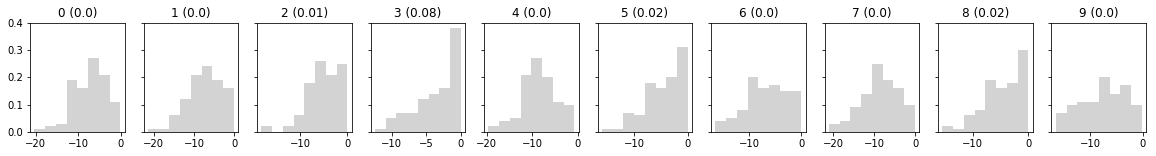

Undecided.


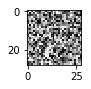

Real:  3


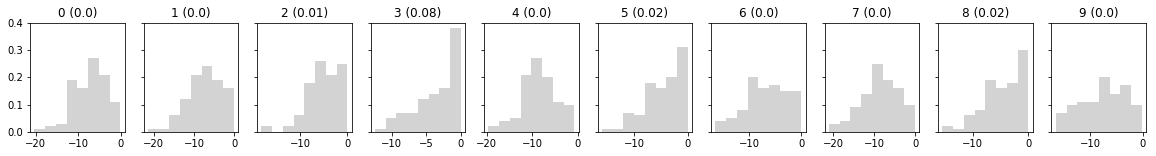

Undecided.


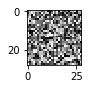

Real:  0


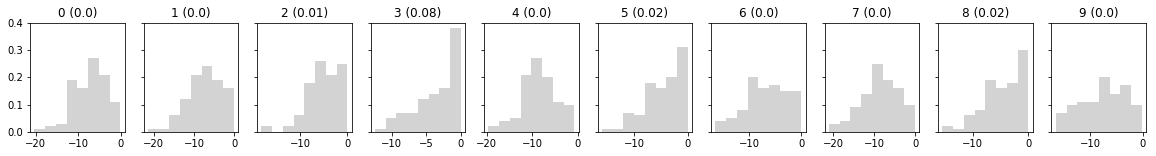

Undecided.


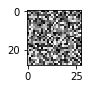

Real:  3


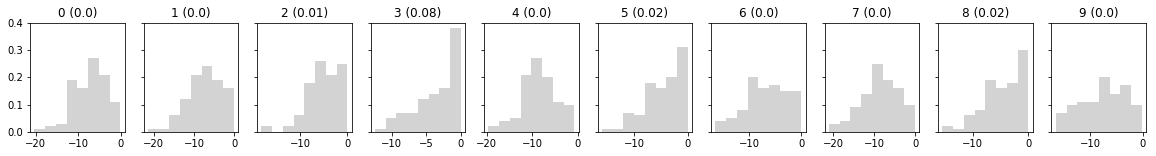

Undecided.


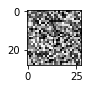

Real:  7


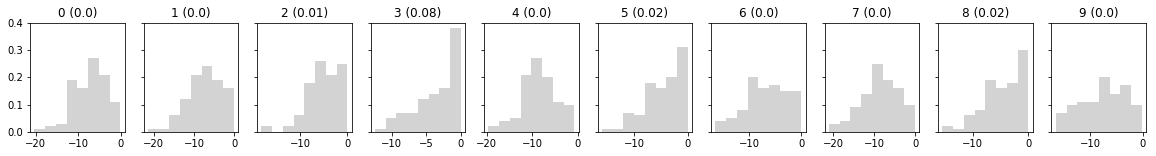

Undecided.


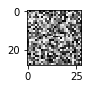

Real:  0


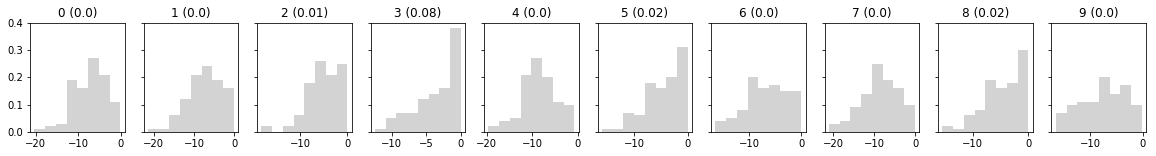

Undecided.


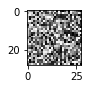

Real:  4


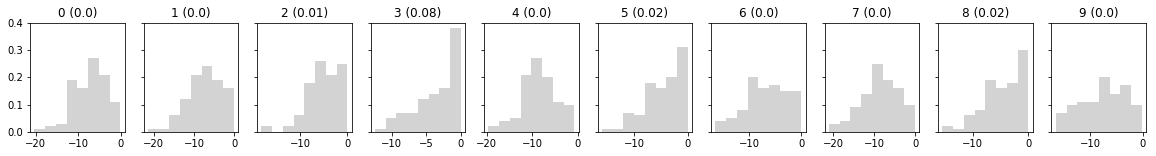

Undecided.


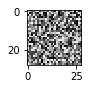

Real:  9


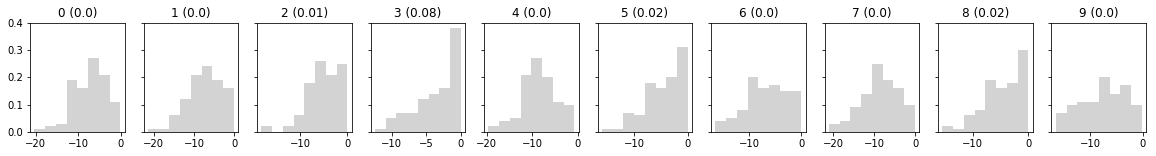

Undecided.


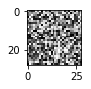

Real:  4


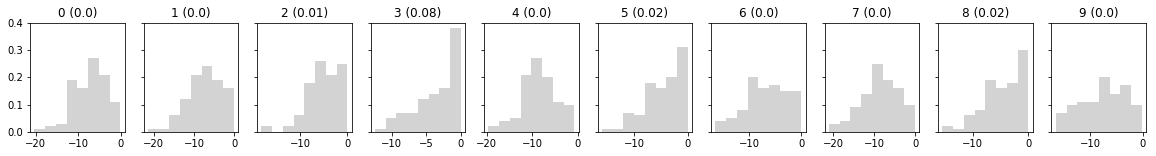

Undecided.


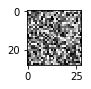

Real:  8


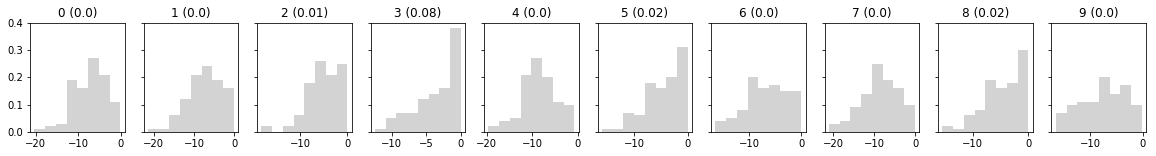

Undecided.


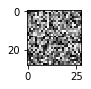

Real:  3


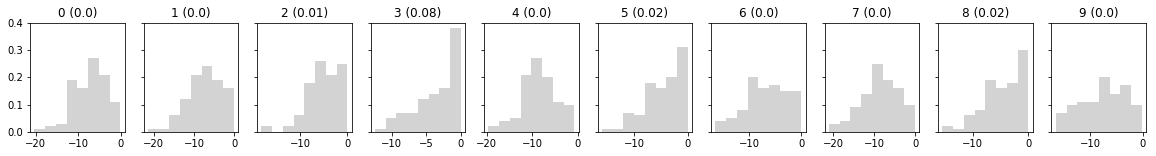

Undecided.


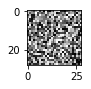

Real:  4


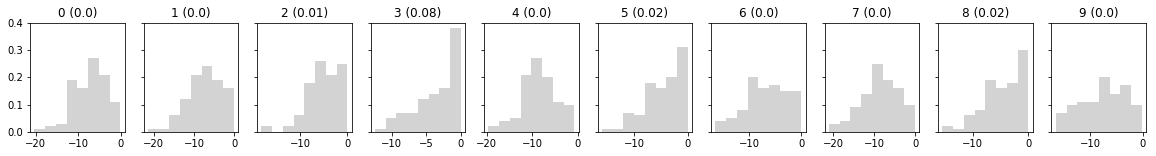

Undecided.


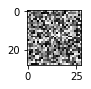

Real:  1


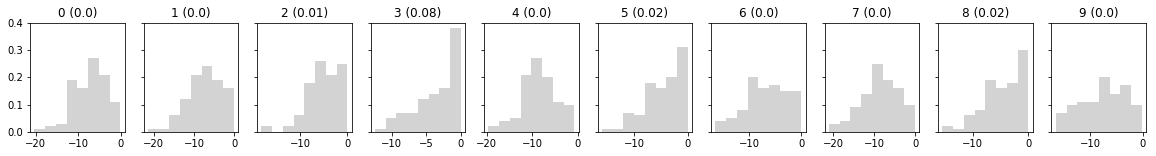

Undecided.


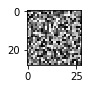

Real:  8


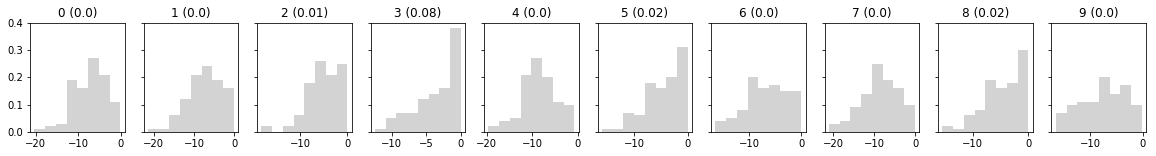

Undecided.


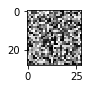

Real:  2


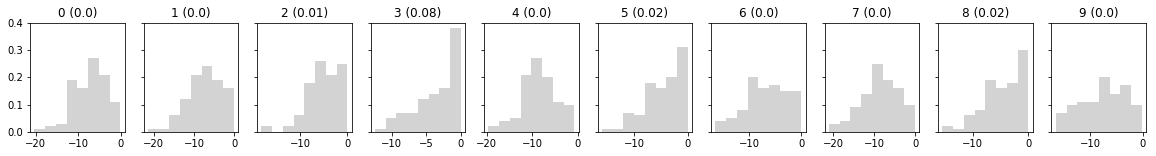

Undecided.


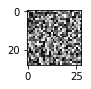

Real:  5


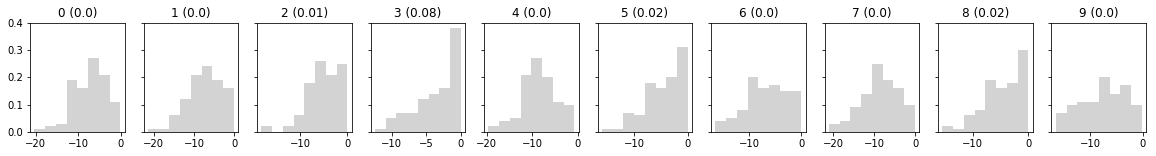

Undecided.


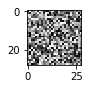

Real:  0


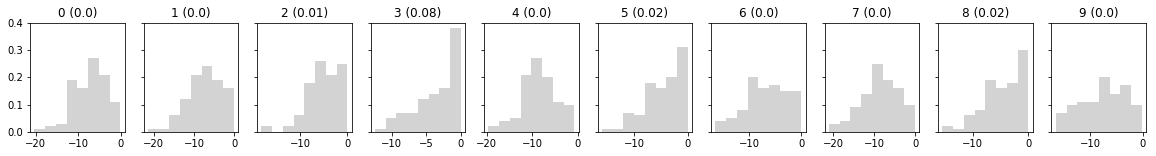

Undecided.


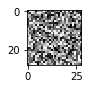

Real:  0


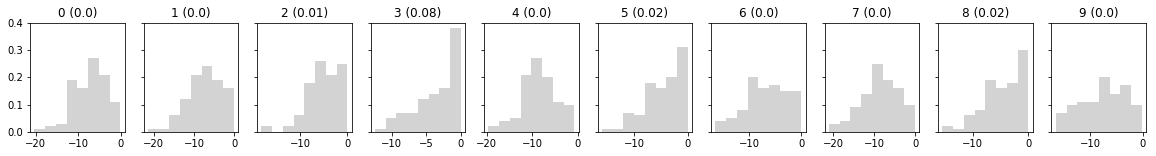

Undecided.


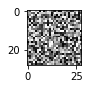

Real:  9


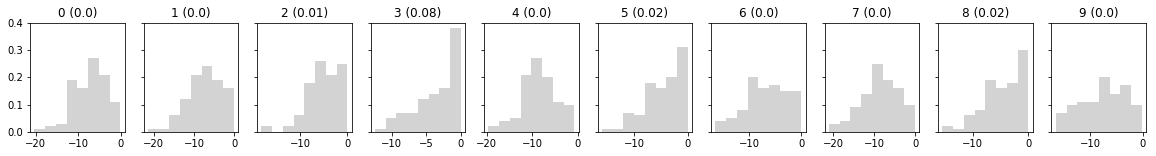

Undecided.


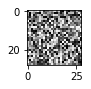

Real:  6


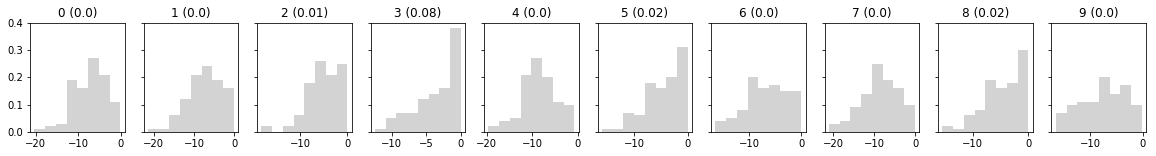

Undecided.


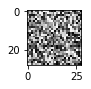

Real:  0


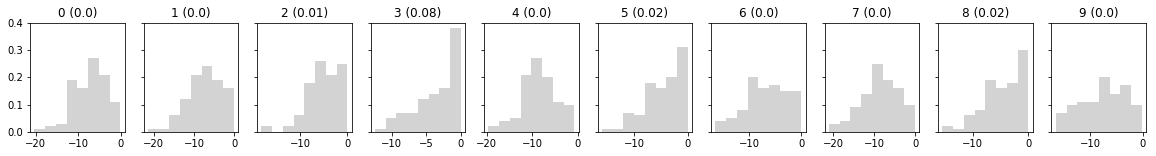

Undecided.


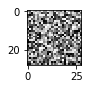

Real:  3


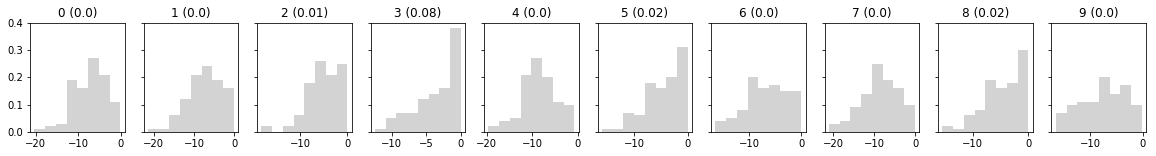

Undecided.


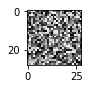

Real:  6


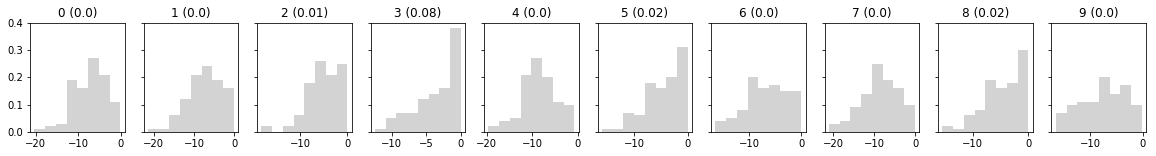

Undecided.


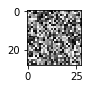

Real:  7


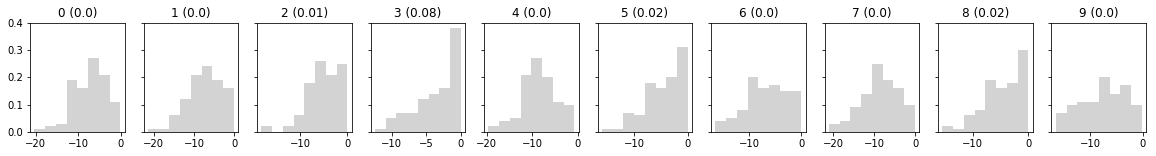

Undecided.


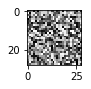

Real:  8


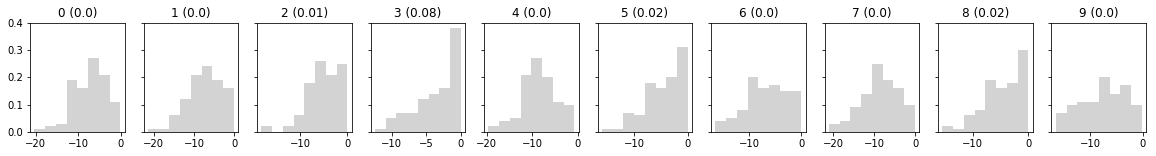

Undecided.


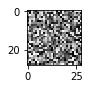

Real:  4


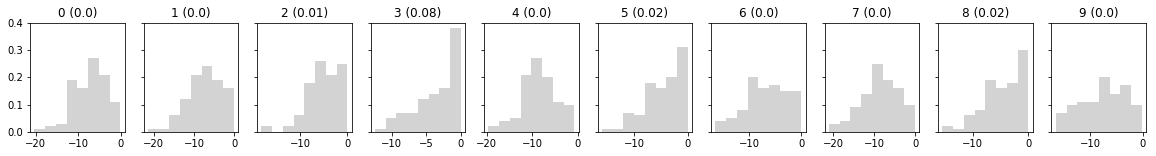

Undecided.


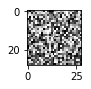

Real:  0


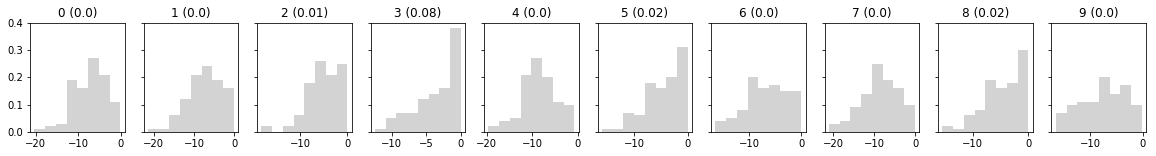

Undecided.


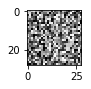

Real:  1


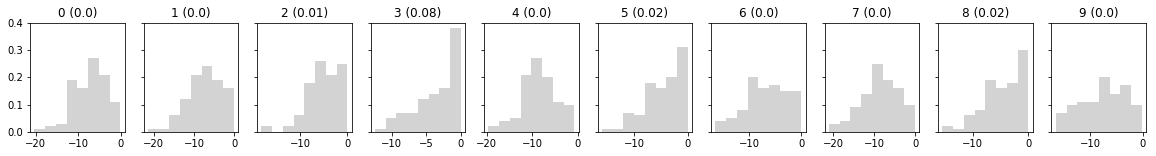

Undecided.


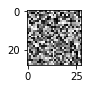

Real:  7


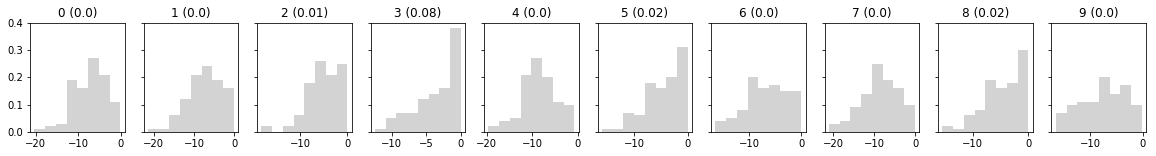

Undecided.


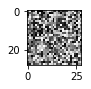

Real:  2


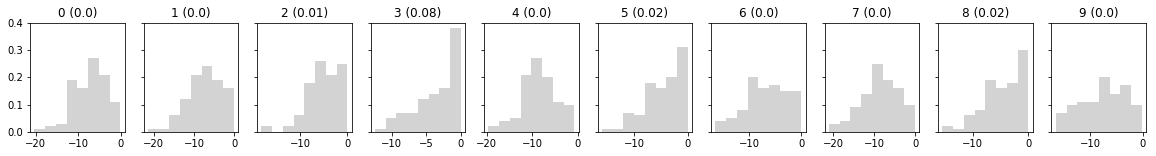

Undecided.


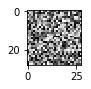

Real:  5


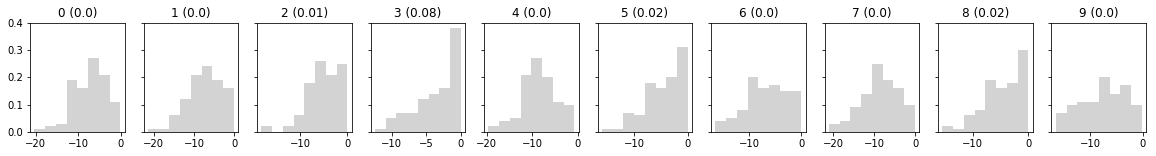

Undecided.


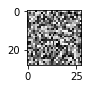

Real:  6


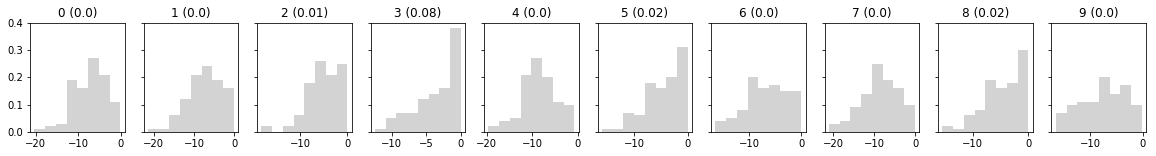

Undecided.


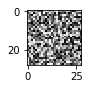

Real:  9


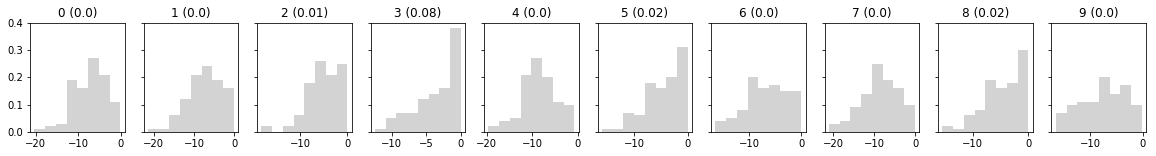

Undecided.


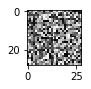

Real:  3


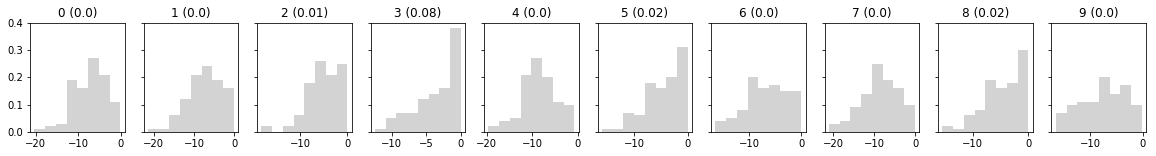

Undecided.


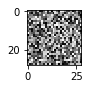

Real:  5


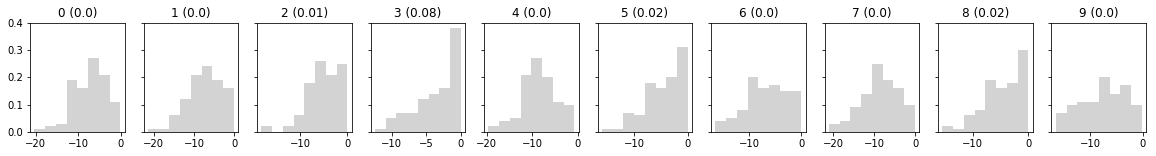

Undecided.


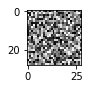

Real:  5


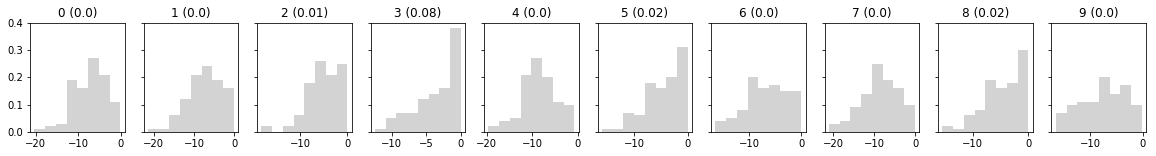

Undecided.


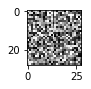

Real:  8


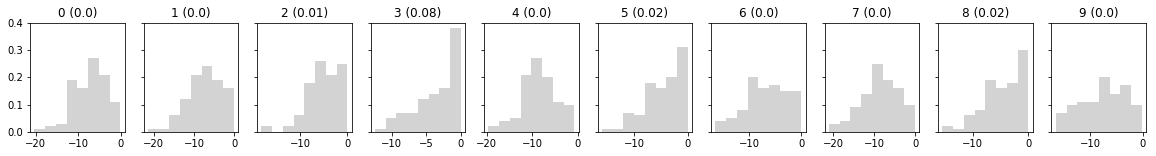

Undecided.


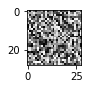

Real:  0


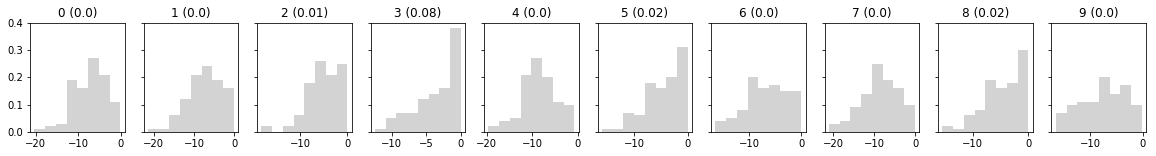

Undecided.


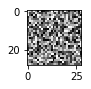

Real:  2


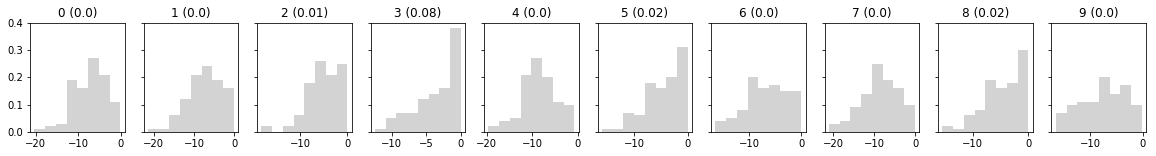

Undecided.


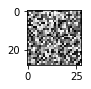

Real:  1


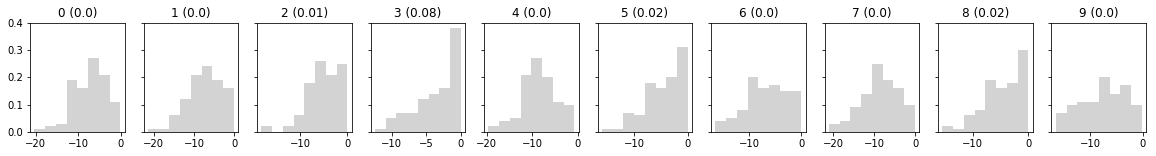

Undecided.


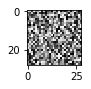

Real:  9


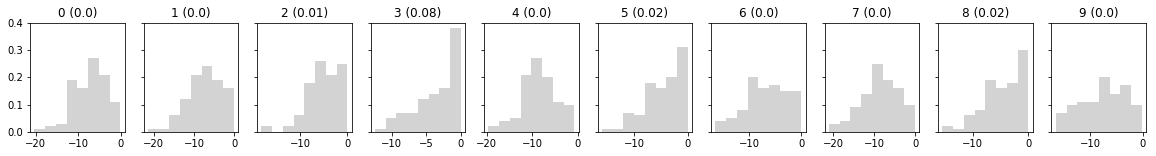

Undecided.


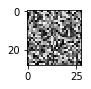

Real:  1


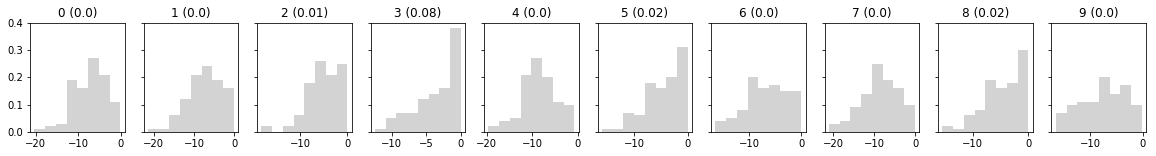

Undecided.


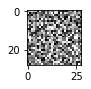

Real:  1


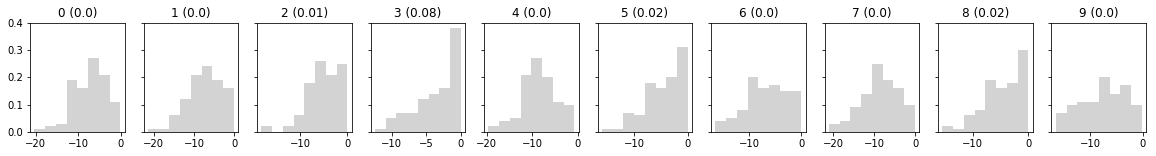

Undecided.


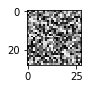

Real:  8


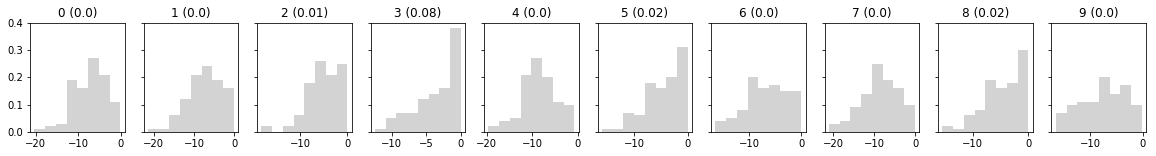

Undecided.


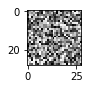

Real:  8


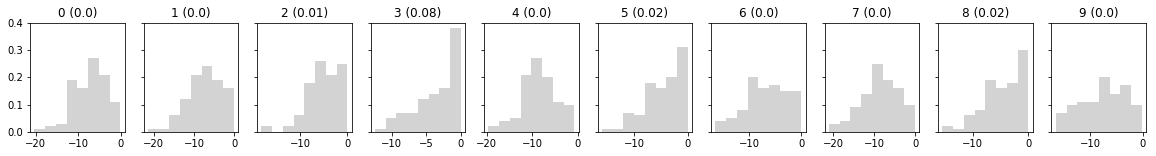

Undecided.


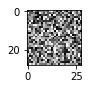

Real:  2


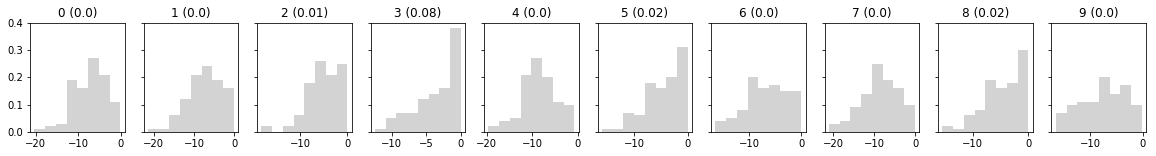

Undecided.


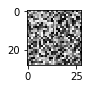

Real:  8


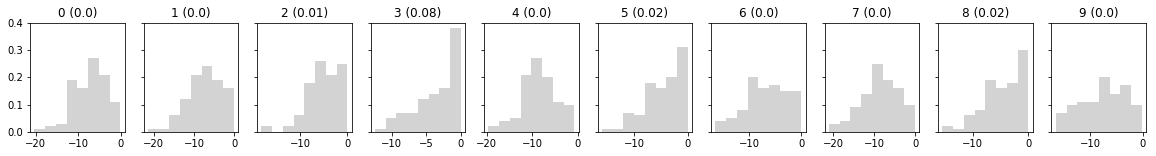

Undecided.


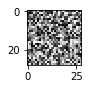

Real:  8


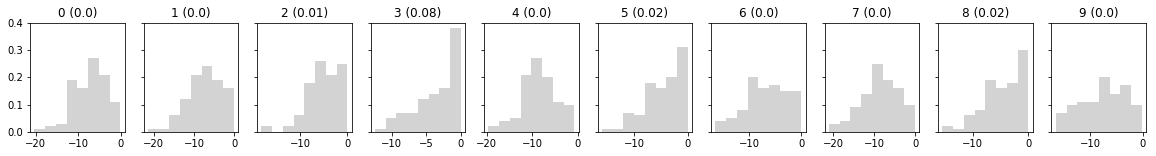

Undecided.


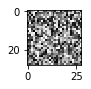

Real:  2


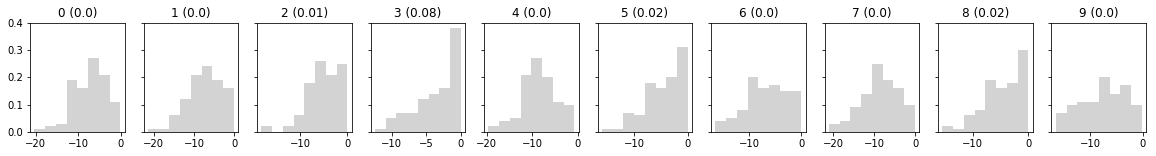

Undecided.


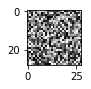

Real:  2


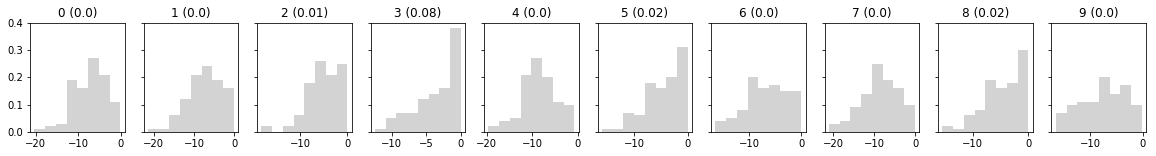

Undecided.


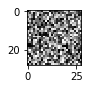

Real:  4


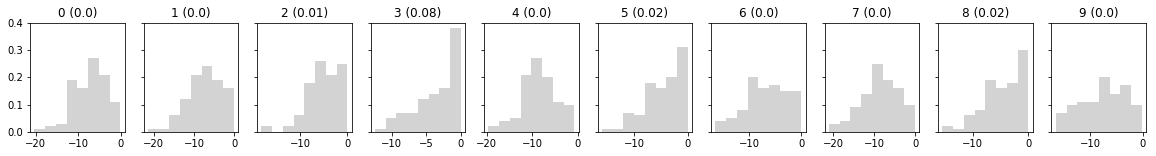

Undecided.


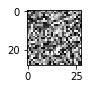

Summary
Total images:  100
Predicted for:  0


ZeroDivisionError: division by zero

In [22]:
test_batch(images_random, labels_random)

In [23]:
class data_loader(Dataset):
	def __init__(self, root):
		Images, Y = [], []
		folders = os.listdir(root)
		folders = folders[1:]

		for folder in folders:
            
			folder_path = os.path.join(root, folder)
			print(folder_path)
            
            
            
			for ims in os.listdir(folder_path):

				img_path = os.path.join(folder_path, ims)
				Images.append(np.array(imread(img_path)))
				Y.append(ord(folder) - 65)  # Folders are A-J so labels will be 0-9
				
		data = [(x, y) for x, y in zip(Images, Y)]
		self.data = data

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		img = self.data[index][0]

		# 8 bit images. Scale between 0, 1
		img = img.reshape(1, 28, 28) / 255

		# Input for Conv2D should be Channels x Height x Width
		img_tensor = transforms.ToTensor()(img).view(1, 28, 28).float()
		label = self.data[index][1]
		return (img_tensor, label)

In [24]:
# NOT Mnist data

test_dataset_notmnist = data_loader('not-mnist')
test_loader_notmnist = DataLoader(test_dataset_notmnist, batch_size=128, shuffle=True)

not-mnist\B


C:\Users\divakar\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


not-mnist\C
not-mnist\D
not-mnist\E
not-mnist\F
not-mnist\G
not-mnist\H
not-mnist\I
not-mnist\J


In [25]:
# Prediction when network can decide not to predict

print('Prediction on not-MNIST when network can refuse')
total = 0
total_predicted_for = 0
for j, data in enumerate(test_loader_notmnist):
    images, labels = data
    total_minibatch, correct_minibatch, predictions_minibatch = test_batch(images, labels, plot=False)
    total += total_minibatch
    total_predicted_for += predictions_minibatch

print("Total images: ", total)
print("Skipped: ", total-total_predicted_for)

Prediction on not-MNIST when network can refuse
Total images:  362
Skipped:  360


In [26]:
dataiter_notmnist = iter(test_loader_notmnist)
images_notmnist, labels_notmnist = dataiter_notmnist.next()

Real:  6


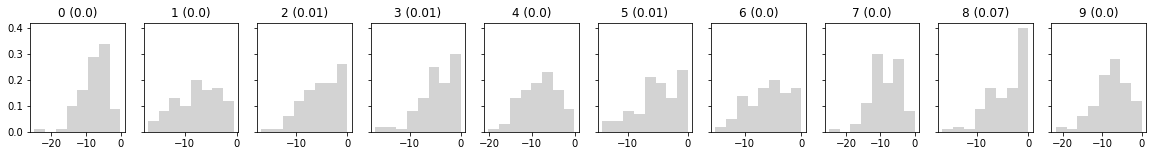

Undecided.


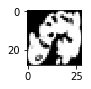

Real:  6


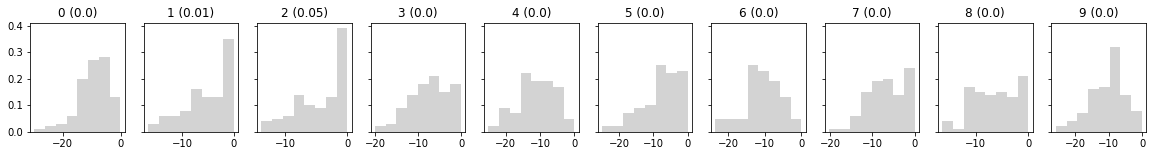

Undecided.


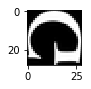

Real:  9


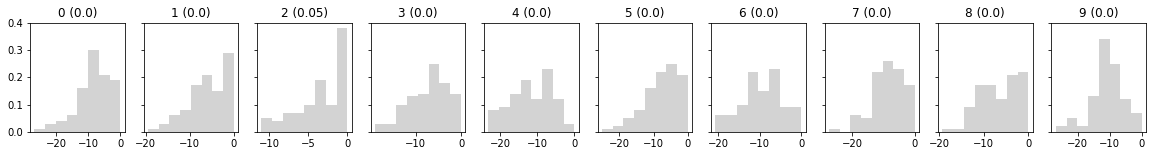

Undecided.


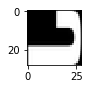

Real:  8


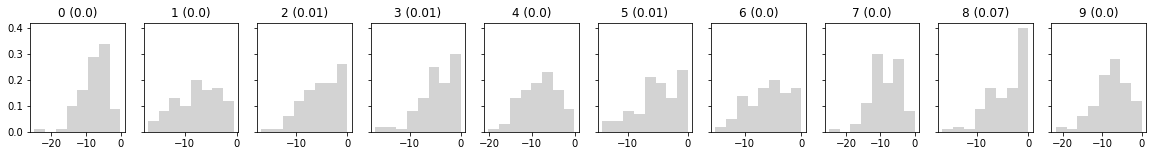

Undecided.


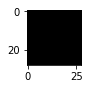

Real:  6


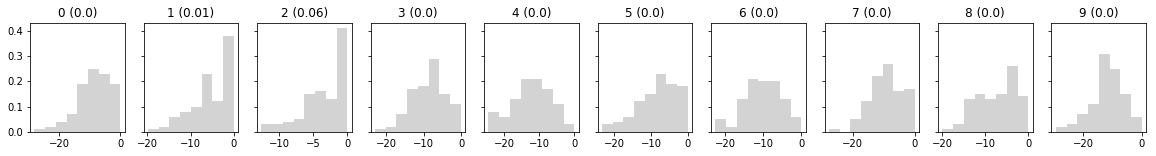

Undecided.


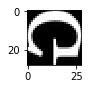

Real:  5


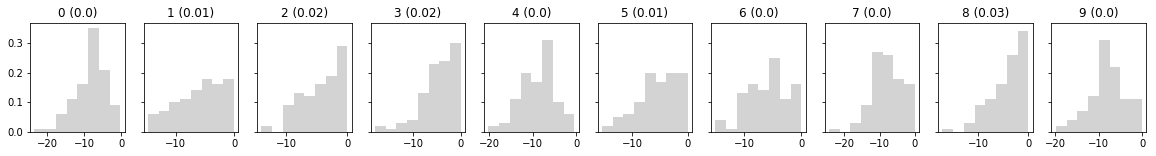

Undecided.


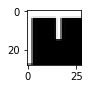

Real:  2


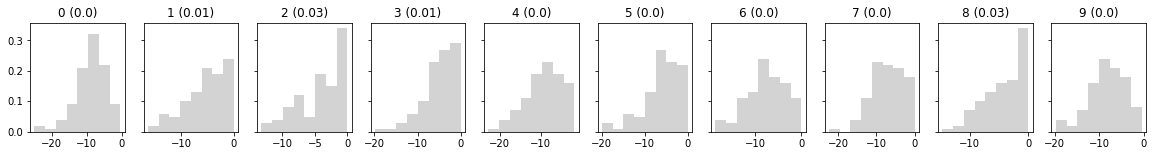

Undecided.


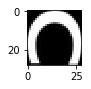

Real:  9


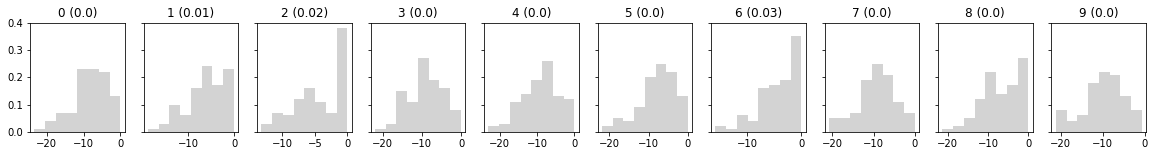

Undecided.


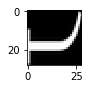

Real:  7


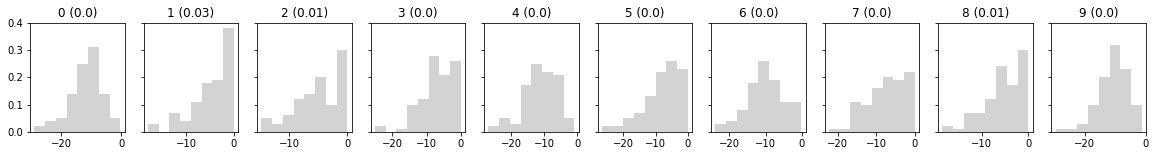

Undecided.


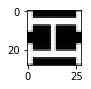

Real:  4


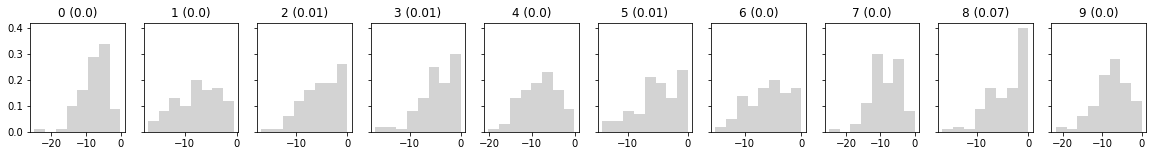

Undecided.


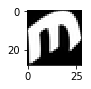

Real:  6


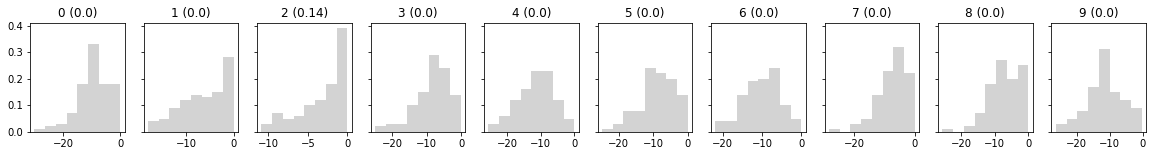

Undecided.


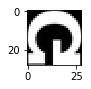

Real:  1


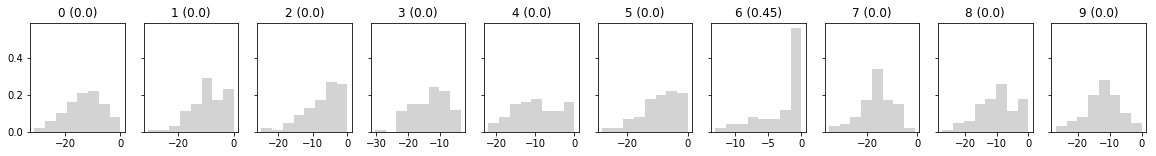

Undecided.


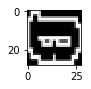

Real:  3


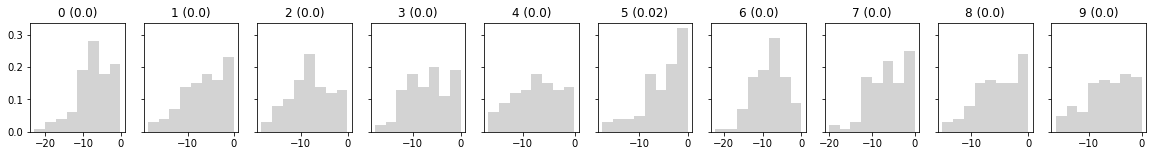

Undecided.


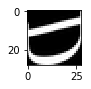

Real:  7


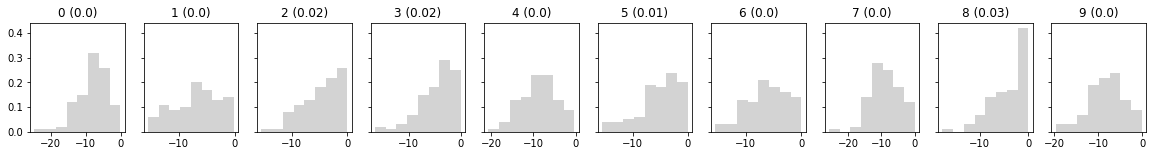

Undecided.


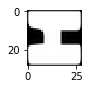

Real:  5


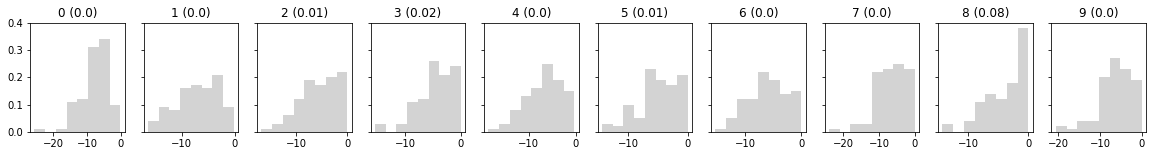

Undecided.


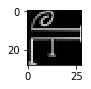

Real:  2


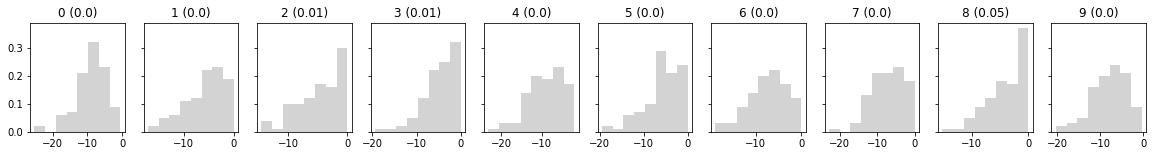

Undecided.


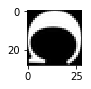

Real:  1


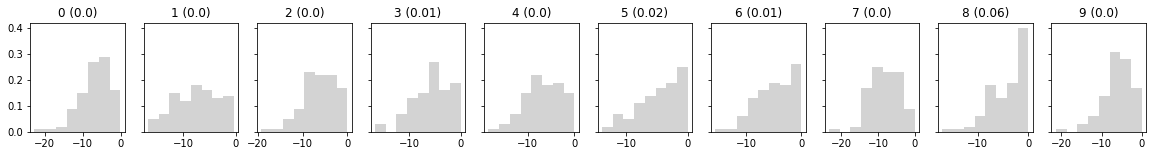

Undecided.


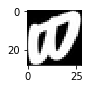

Real:  1


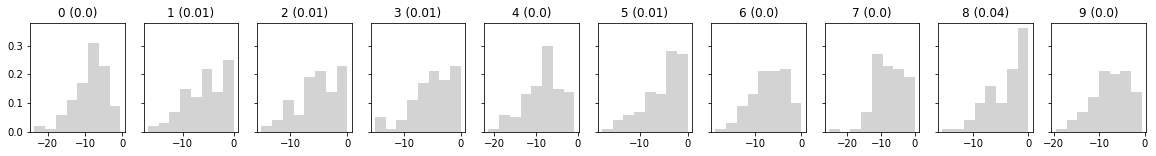

Undecided.


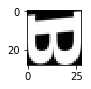

Real:  3


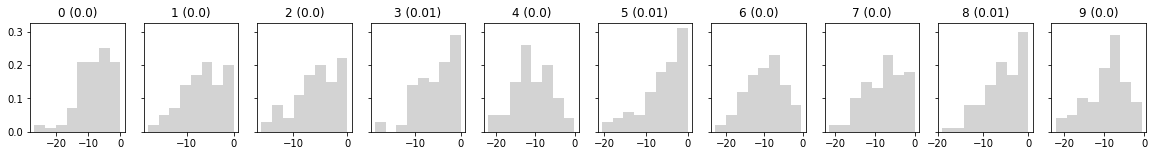

Undecided.


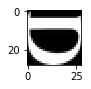

Real:  6


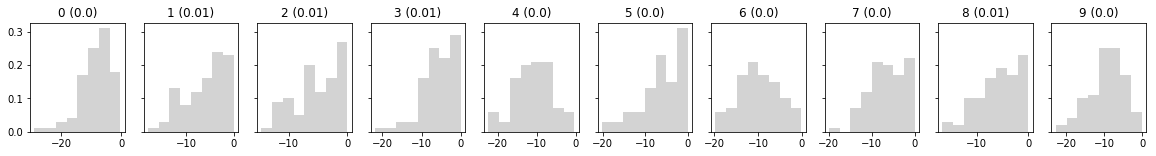

Undecided.


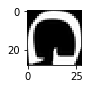

Real:  9


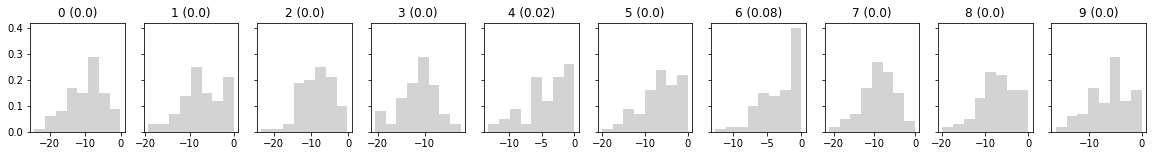

Undecided.


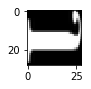

Real:  8


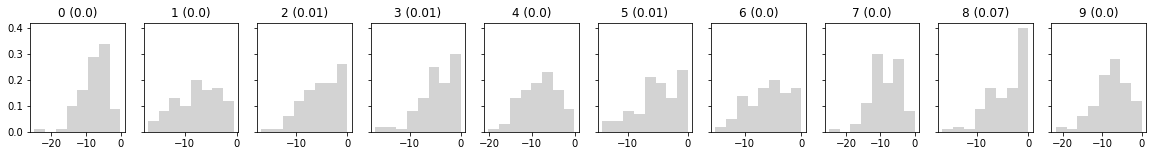

Undecided.


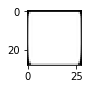

Real:  2


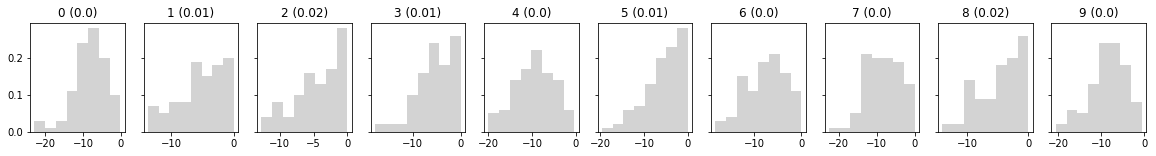

Undecided.


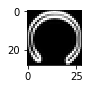

Real:  5


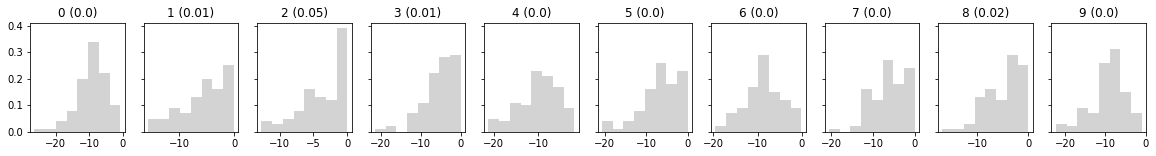

Undecided.


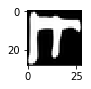

Real:  5


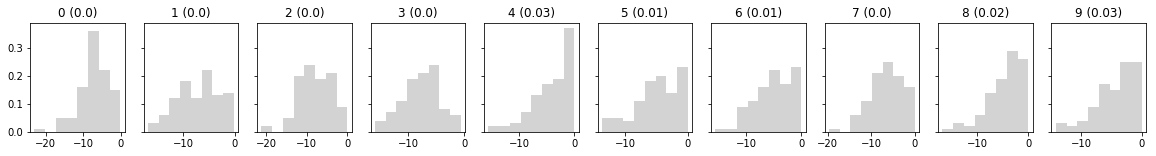

Undecided.


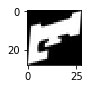

Real:  7


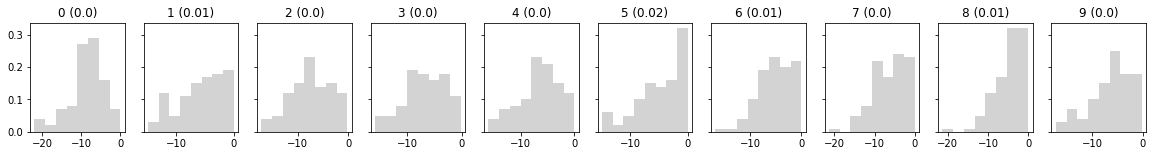

Undecided.


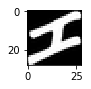

Real:  4


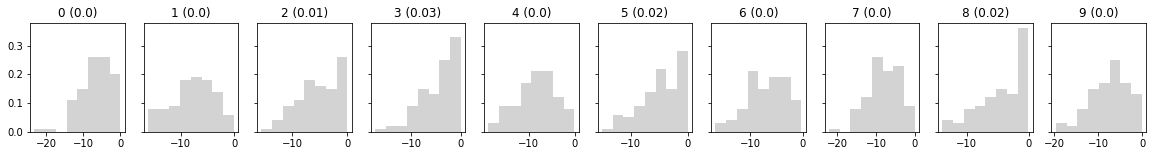

Undecided.


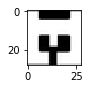

Real:  1


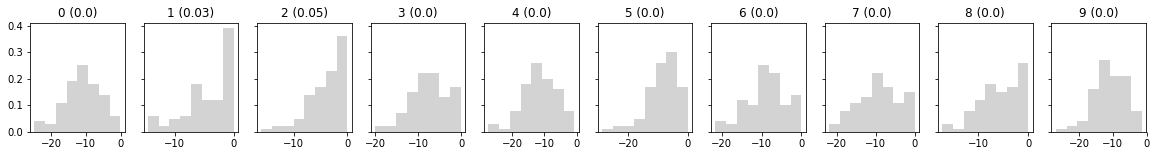

Undecided.


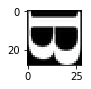

Real:  1


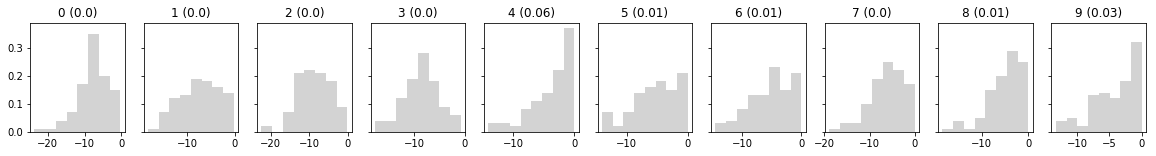

Undecided.


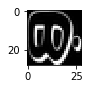

Real:  2


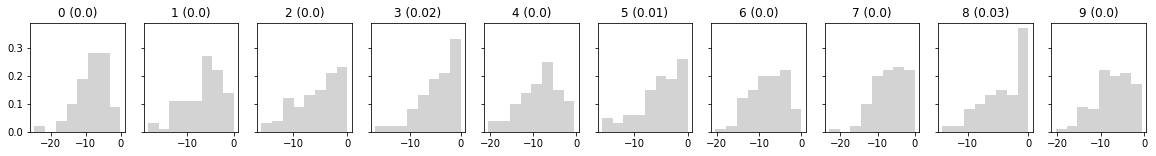

Undecided.


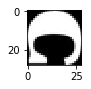

Real:  3


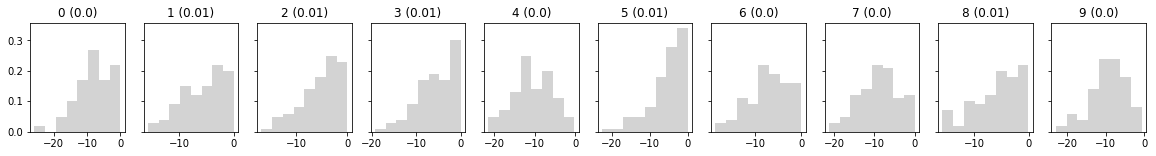

Undecided.


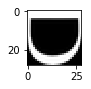

Real:  5


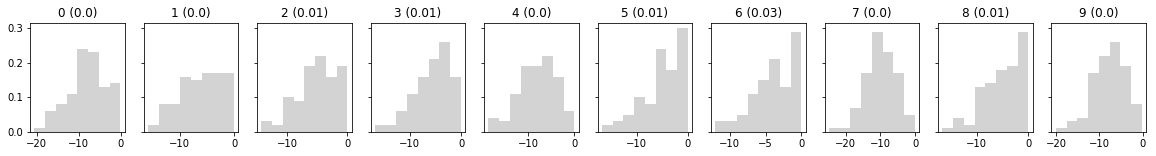

Undecided.


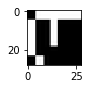

Real:  1


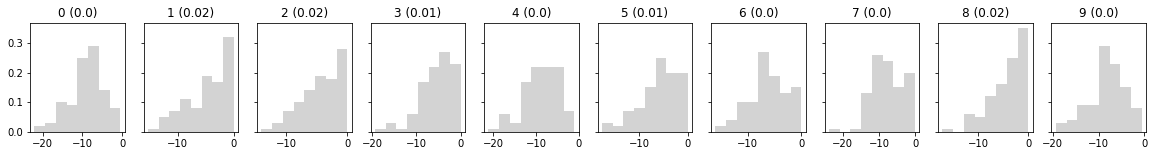

Undecided.


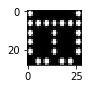

Real:  5


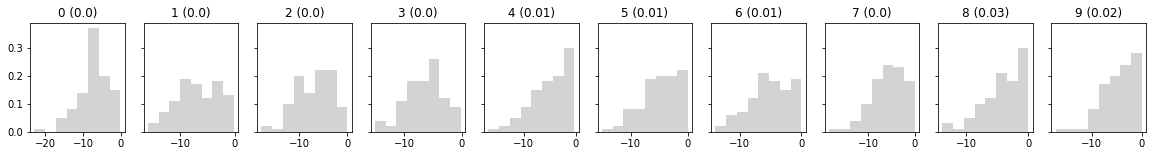

Undecided.


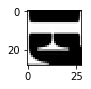

Real:  3


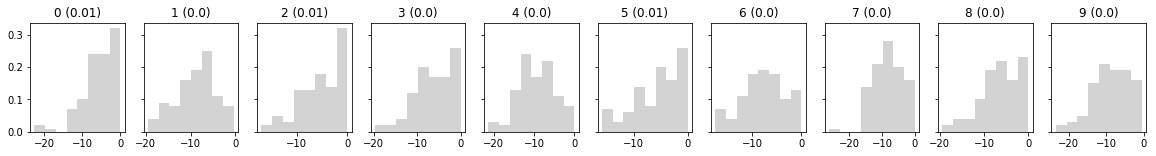

Undecided.


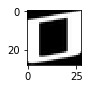

Real:  4


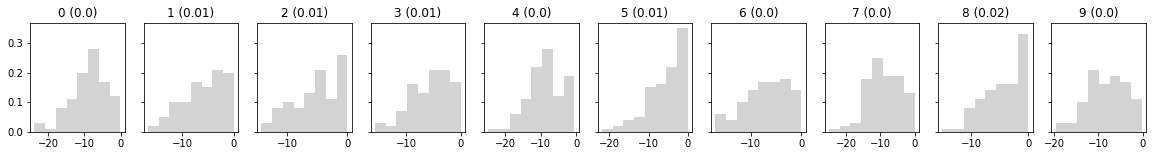

Undecided.


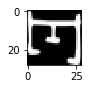

Real:  8


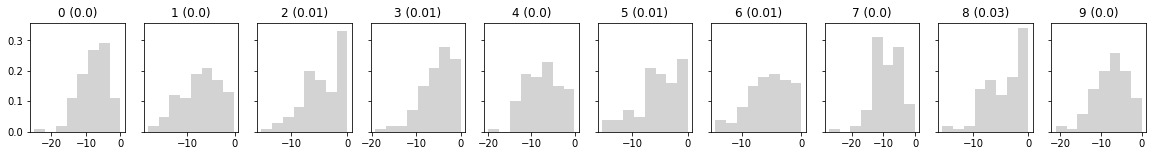

Undecided.


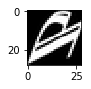

Real:  5


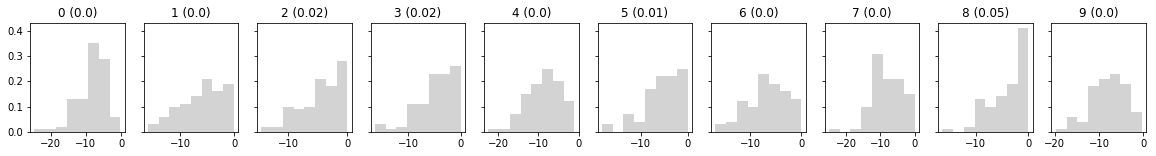

Undecided.


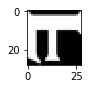

Real:  3


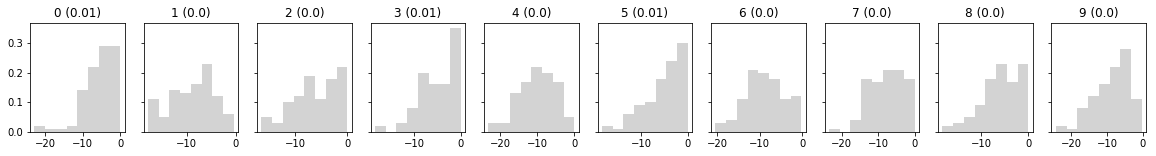

Undecided.


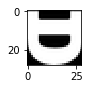

Real:  3


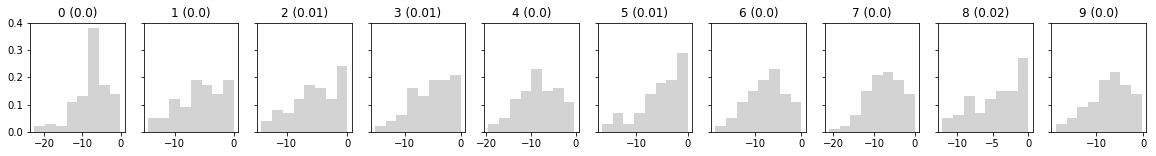

Undecided.


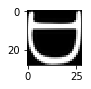

Real:  7


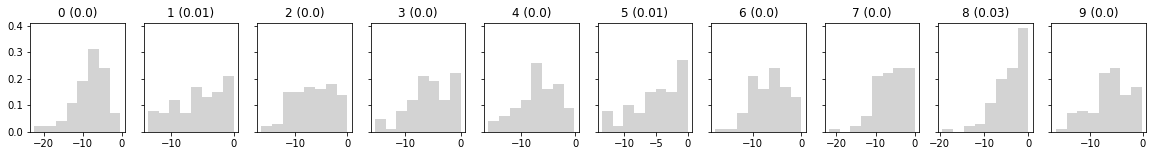

Undecided.


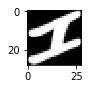

Real:  3


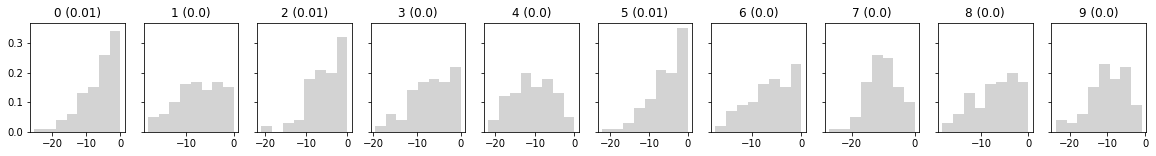

Undecided.


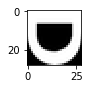

Real:  4


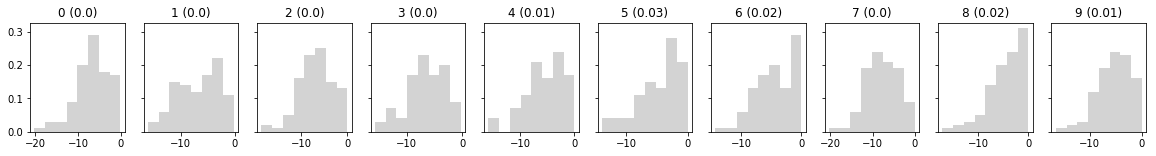

Undecided.


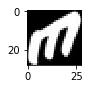

Real:  1


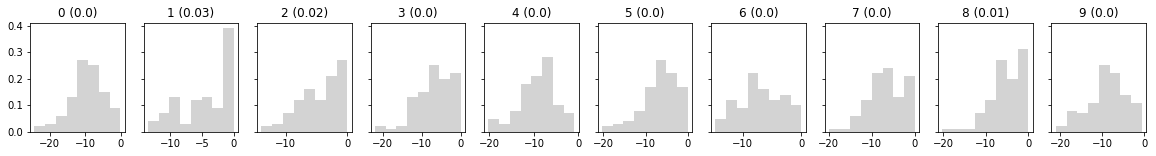

Undecided.


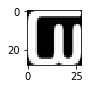

Real:  5


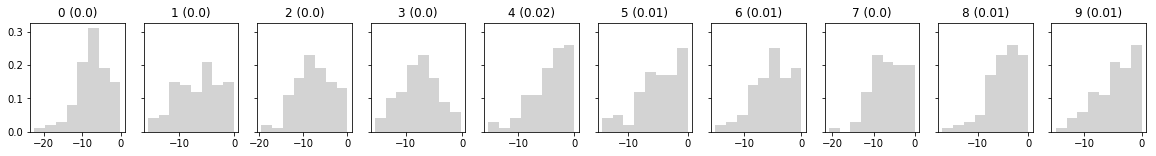

Undecided.


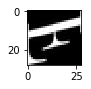

Real:  8


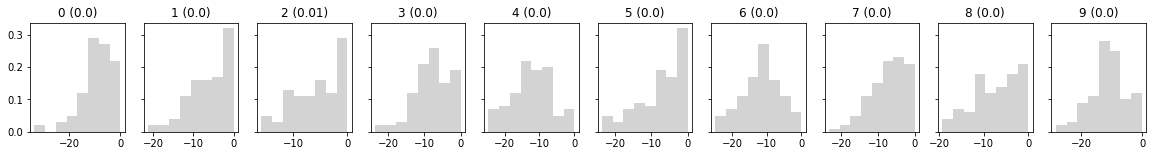

Undecided.


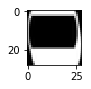

Real:  2


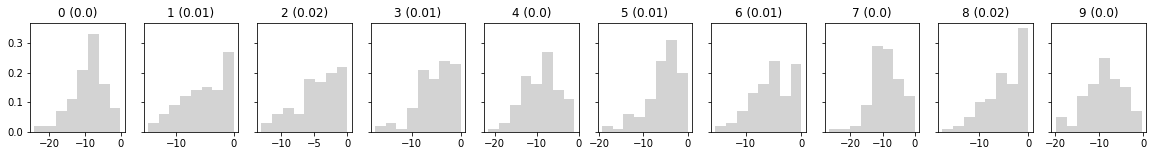

Undecided.


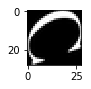

Real:  3


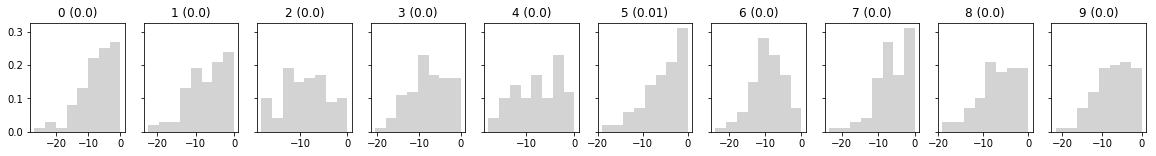

Undecided.


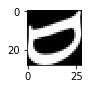

Real:  6


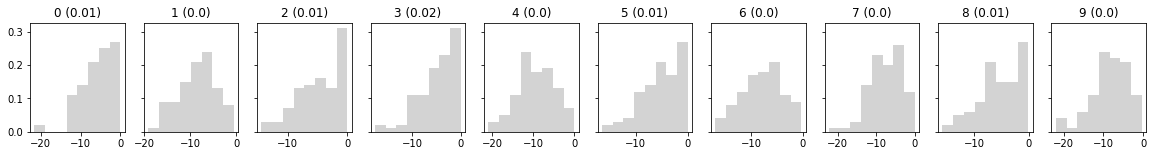

Undecided.


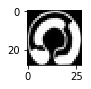

Real:  9


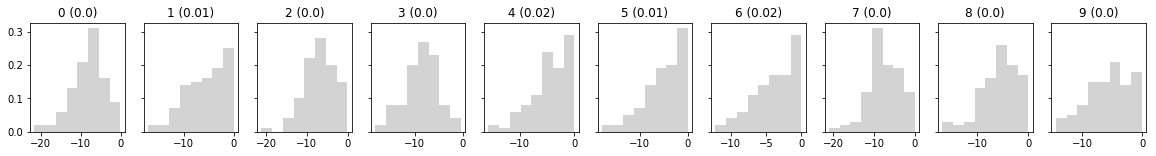

Undecided.


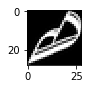

Real:  6


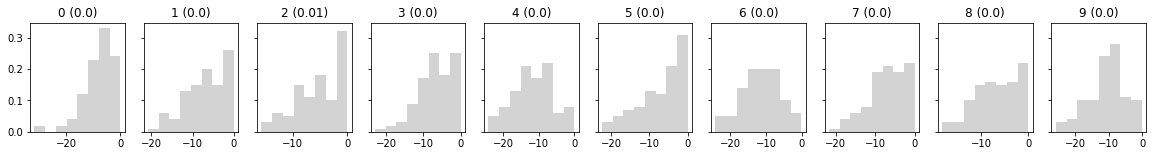

Undecided.


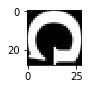

Real:  2


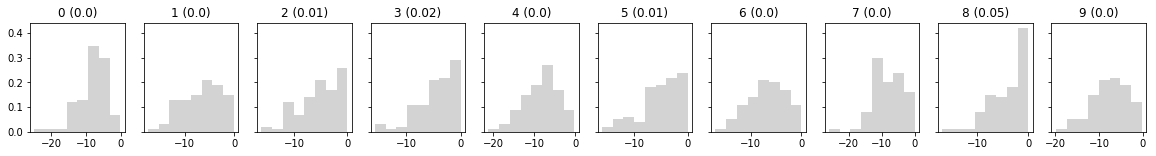

Undecided.


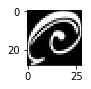

Real:  4


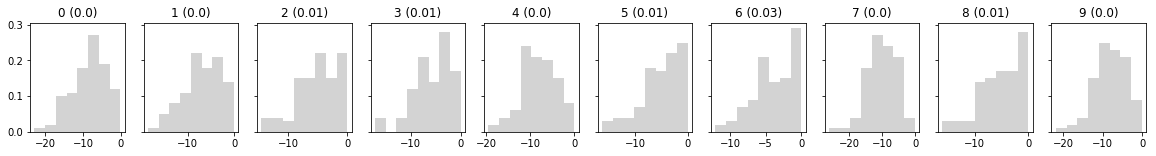

Undecided.


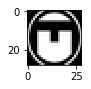

Real:  4


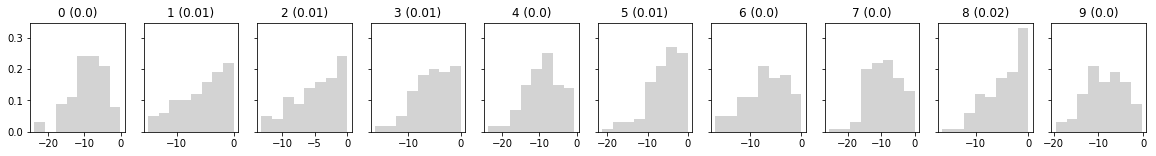

Undecided.


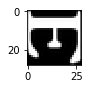

Real:  5


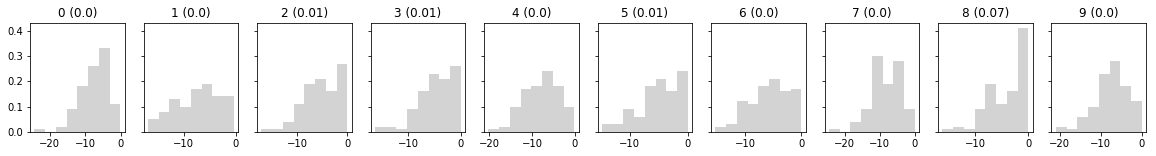

Undecided.


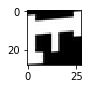

Real:  2


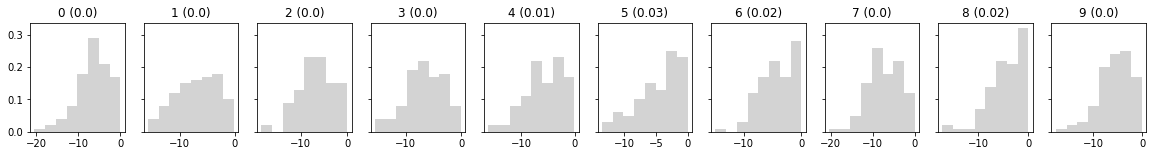

Undecided.


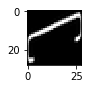

Real:  6


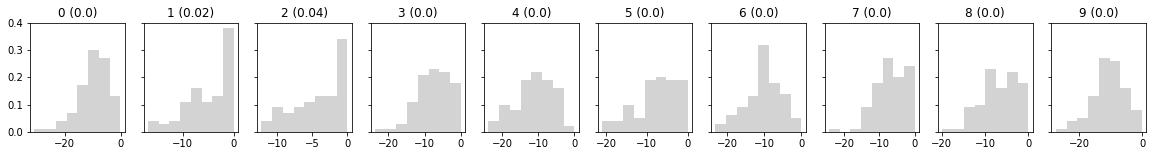

Undecided.


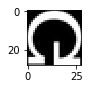

Real:  6


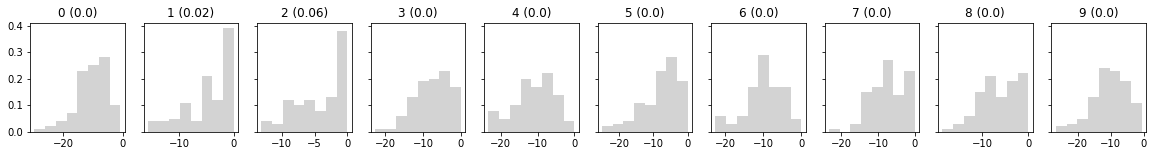

Undecided.


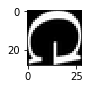

Real:  8


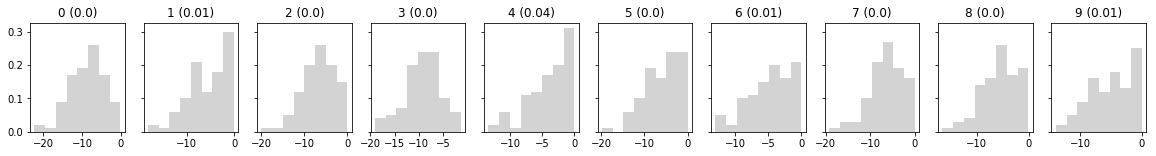

Undecided.


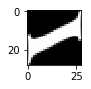

Real:  9


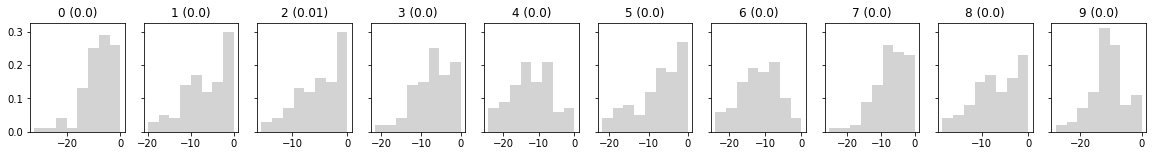

Undecided.


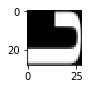

Real:  2


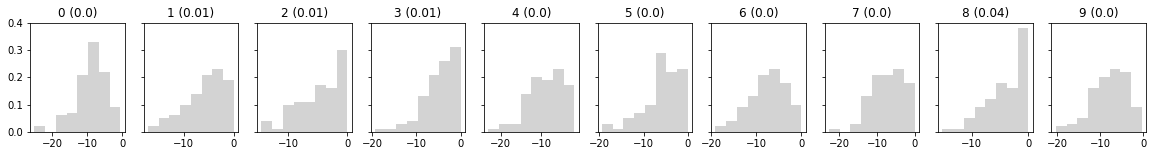

Undecided.


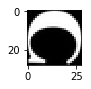

Real:  7


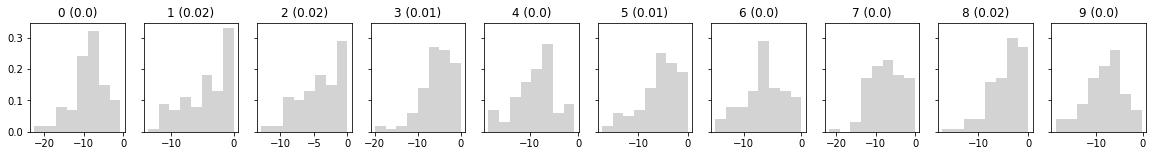

Undecided.


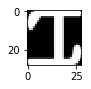

Real:  4


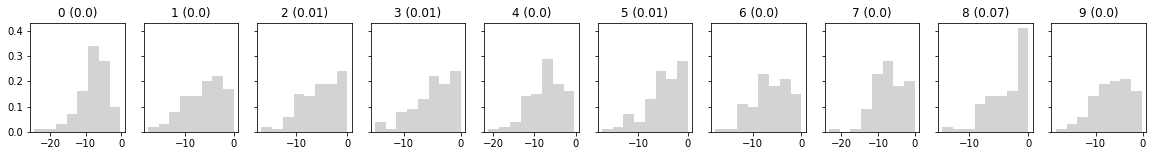

Undecided.


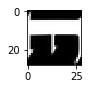

Real:  4


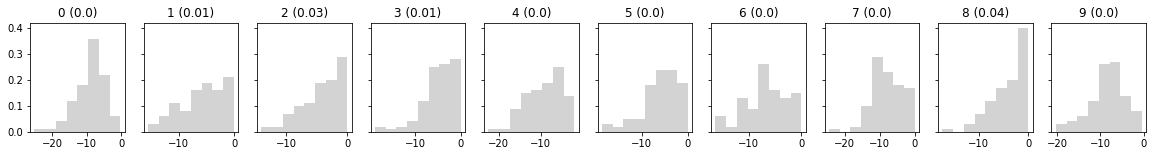

Undecided.


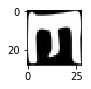

Real:  2


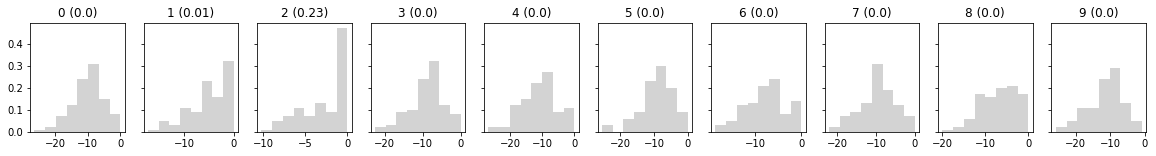

Undecided.


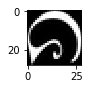

Real:  9


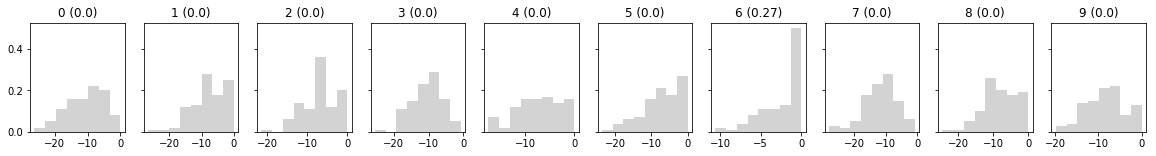

Undecided.


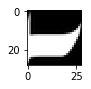

Real:  5


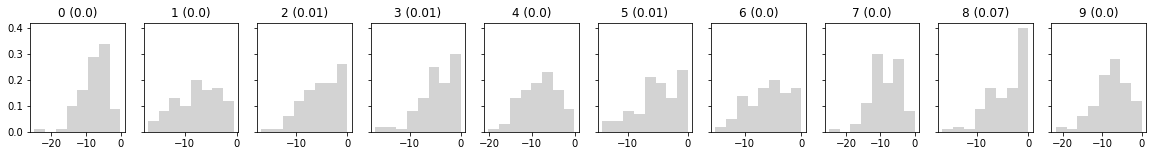

Undecided.


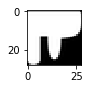

Real:  2


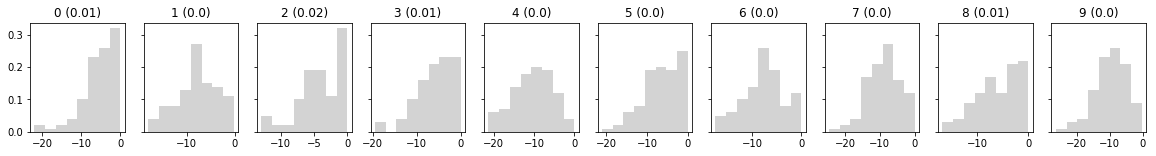

Undecided.


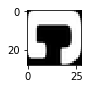

Real:  3


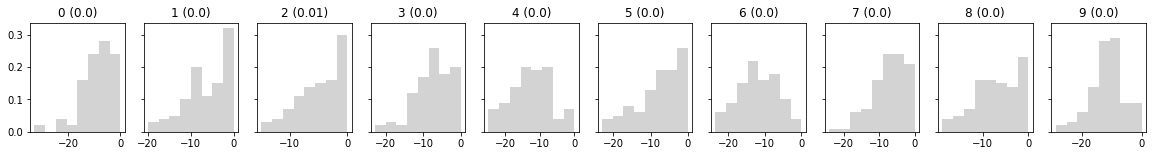

Undecided.


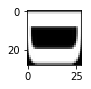

Real:  8


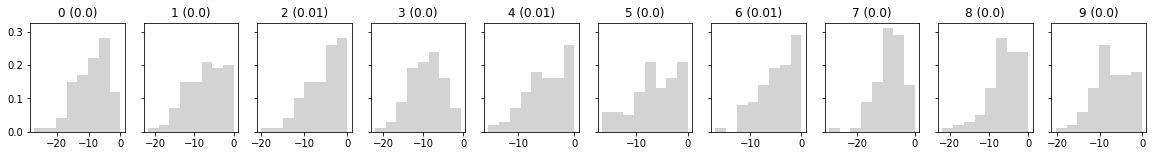

Undecided.


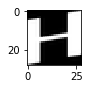

Real:  9


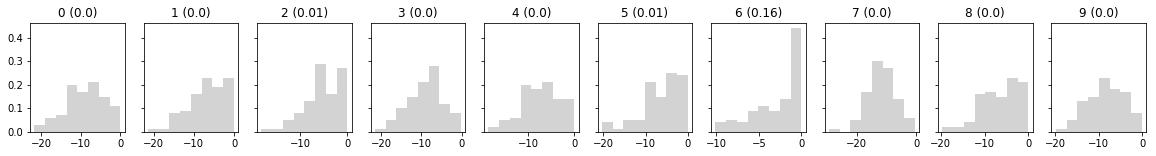

Undecided.


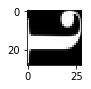

Real:  9


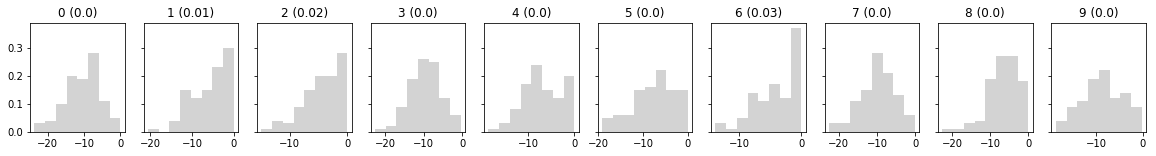

Undecided.


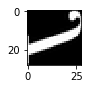

Real:  6


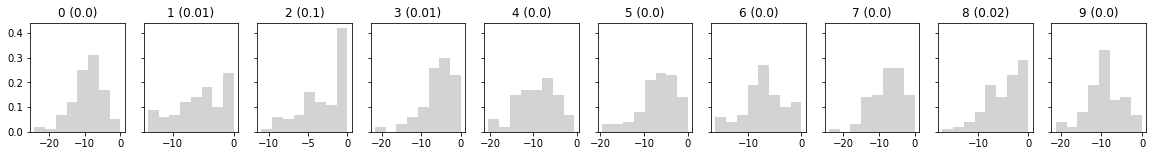

Undecided.


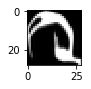

Real:  3


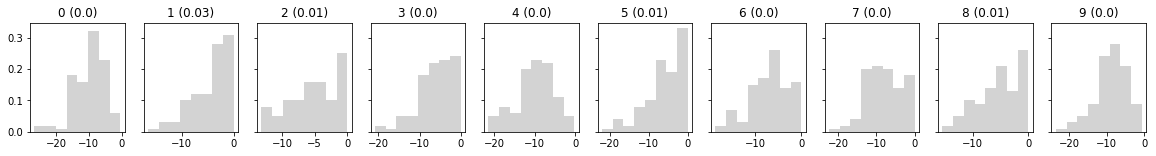

Undecided.


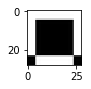

Real:  1


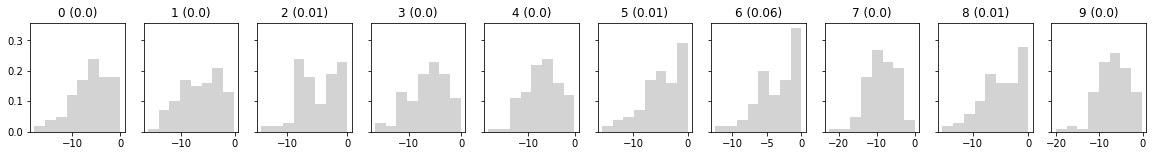

Undecided.


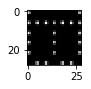

Real:  9


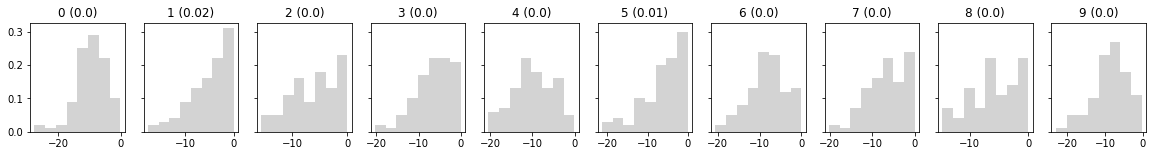

Undecided.


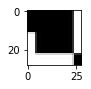

Real:  8


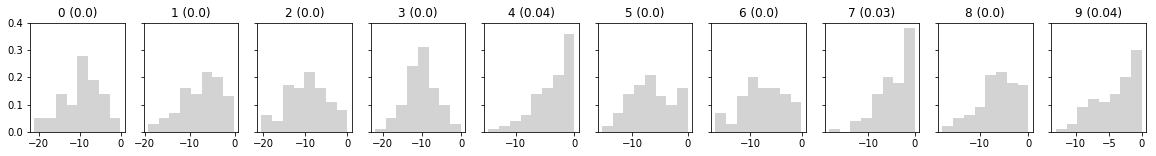

Undecided.


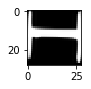

Real:  8


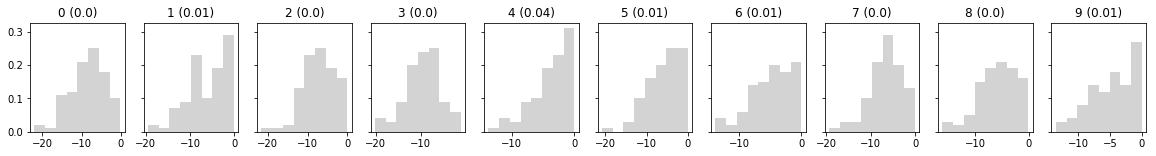

Undecided.


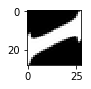

Real:  3


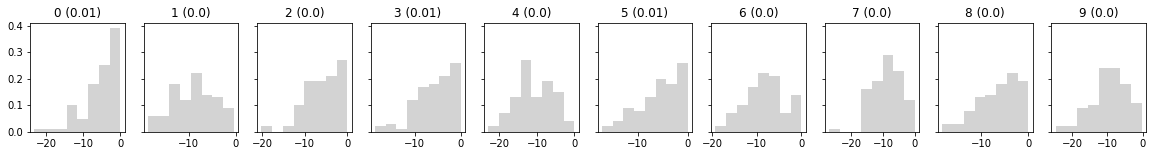

Undecided.


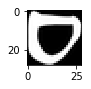

Real:  9


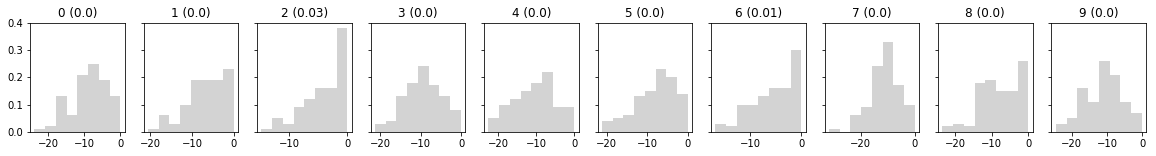

Undecided.


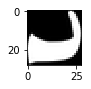

Real:  2


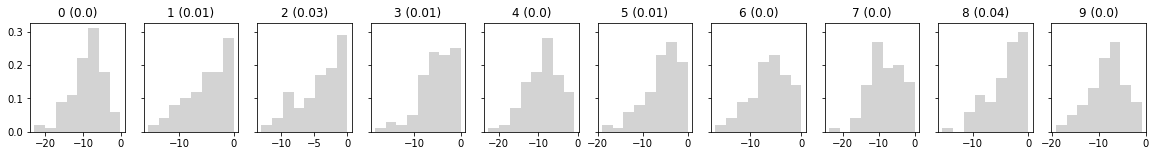

Undecided.


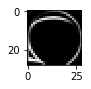

Real:  5


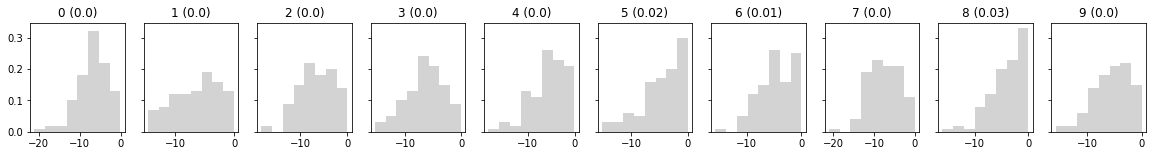

Undecided.


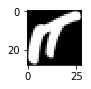

Real:  5


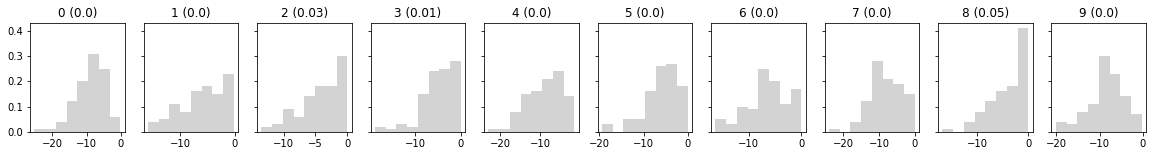

Undecided.


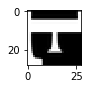

Real:  1


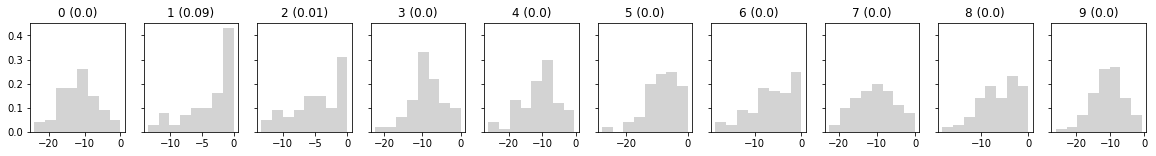

Undecided.


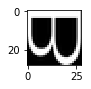

Real:  9


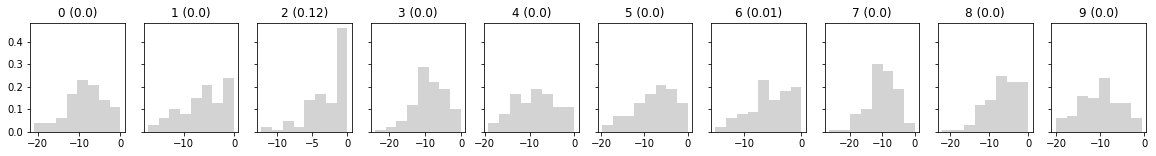

Undecided.


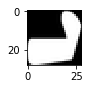

Real:  4


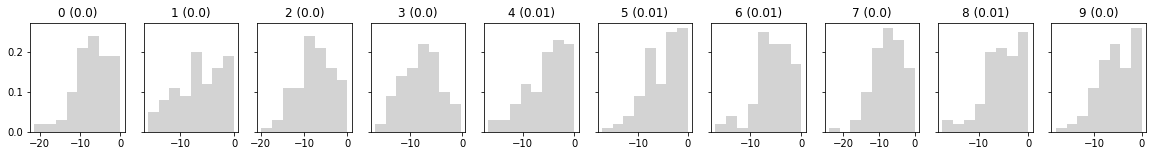

Undecided.


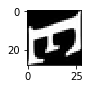

Real:  4


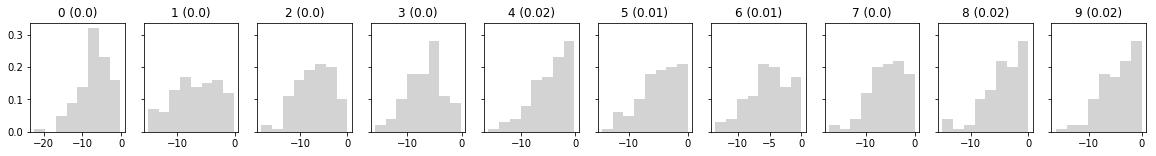

Undecided.


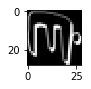

Real:  2


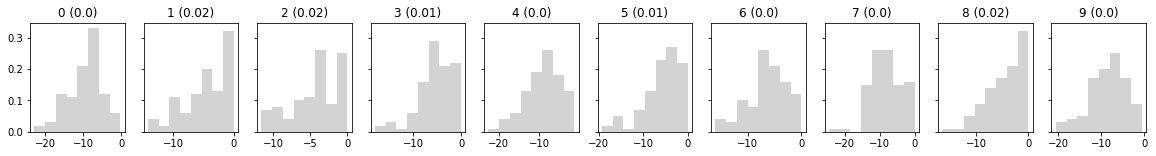

Undecided.


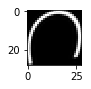

Real:  9


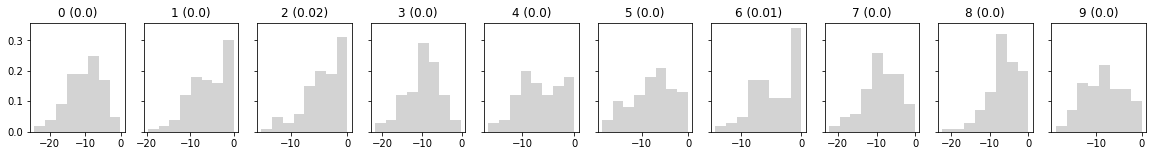

Undecided.


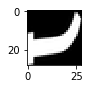

Real:  3


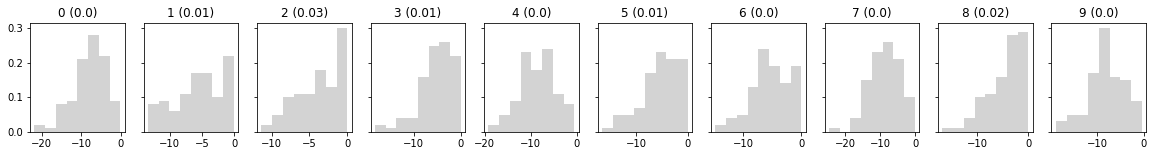

Undecided.


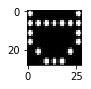

Real:  2


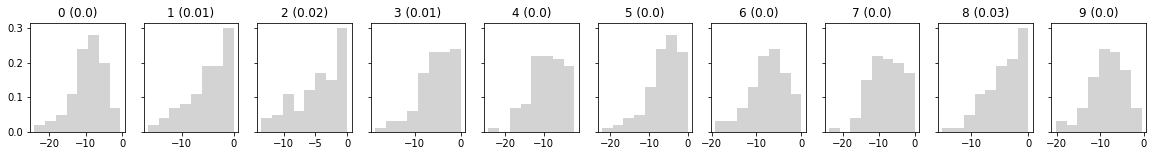

Undecided.


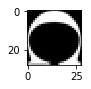

Real:  7


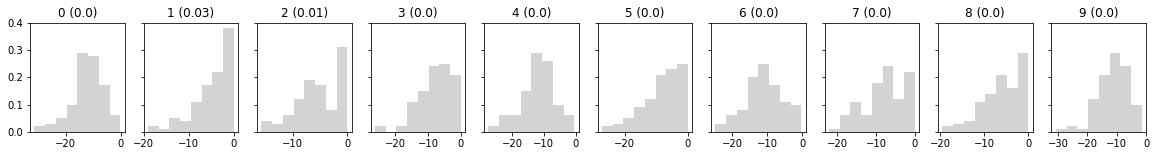

Undecided.


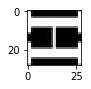

Real:  5


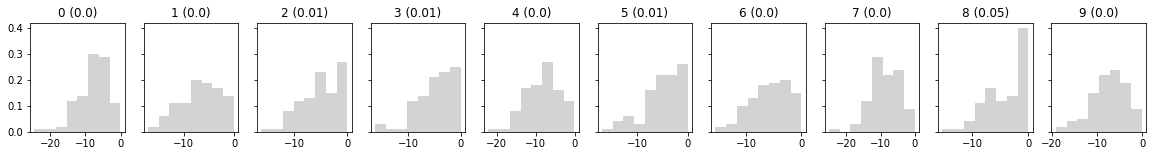

Undecided.


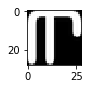

Real:  5


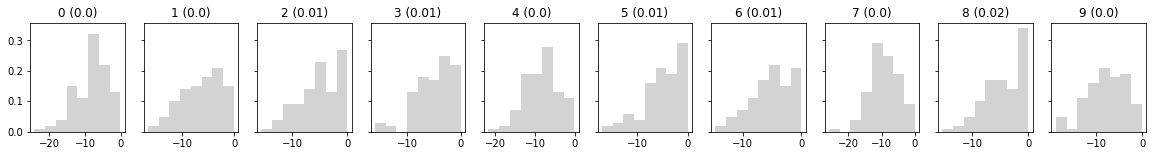

Undecided.


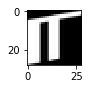

Real:  6


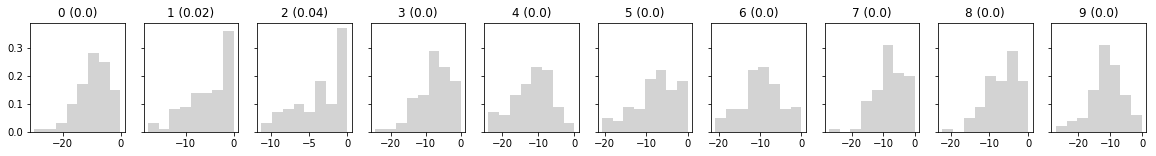

Undecided.


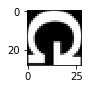

Real:  8


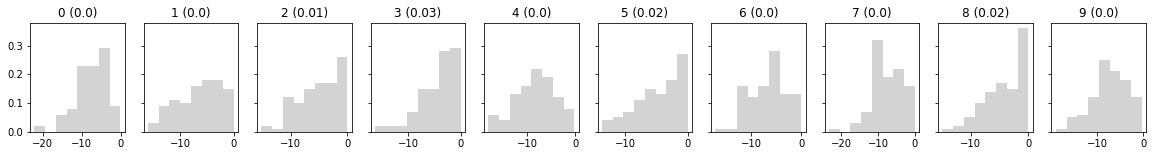

Undecided.


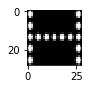

Real:  2


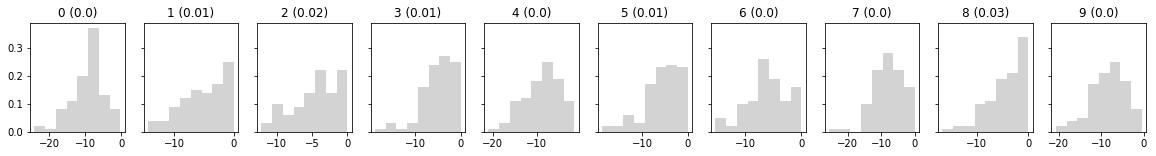

Undecided.


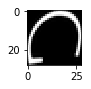

Real:  5


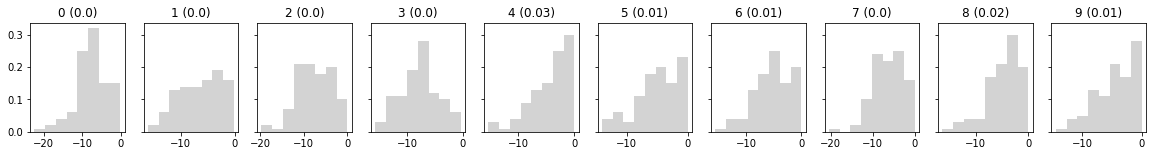

Undecided.


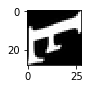

Real:  9


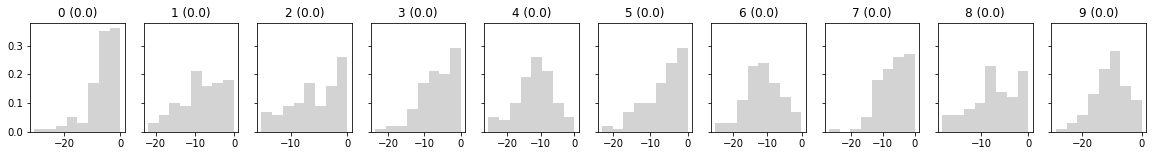

Undecided.


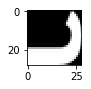

Real:  7


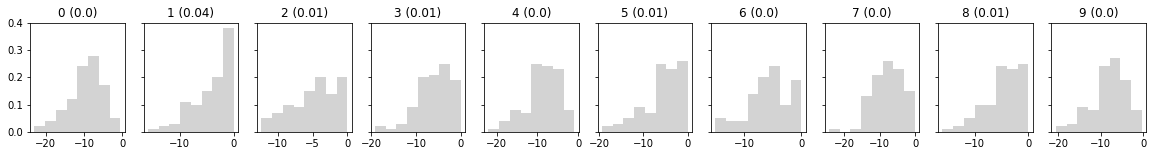

Undecided.


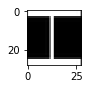

Summary
Total images:  100
Predicted for:  0


ZeroDivisionError: division by zero

In [27]:
test_batch(images_notmnist[:100], labels_notmnist[:100])